# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Modles

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
load_libs()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0.
plt.rcParams['axes.ymargin'] = 0.

## 1.2 Read Data

In [2]:
# ipath= "./data/NCDC/us/baltimore/dat.txt" # time too short
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # 4?
# ipath= './data/NCDC/uk/middle_wallop/dat.txt' # good
# ipath= './data/NCDC/uk/southhamption/dat.txt' # high 0
# ipath= './data/NCDC/uk/bournemouth/dat.txt' 4?
ipath= './data/NCDC/uk/tiree/dat.txt'  # try 4
# ipath= "./data/NCDC/uk/bealach_na_ba/dat.txt" # 
# ipath= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# ipath= "./data/NCDC/uk/south_uist_range/dat.txt" 
# ipath= './data/NCDC/uk/marham/dat.txt' 
# ipath= "./data/NCDC/uk/holbeach/dat.txt"
# ipath= "./data/NCDC/uk/weybourne/dat.txt"
# ipath= "./data/NCDC/uk/cambridge/dat.txt"
# ipath= "./data/NCDC/uk/wattisham/dat.txt"
# ipath= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# ipath= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # 4 or 5?
# ipath= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# ipath= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # 2010-2014 has problem
# ipath= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # 2005-2009  may have problem, fit is good
# ipath= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem, but fit is generally good

# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# ipath= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s)
# ipath= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# ipath= './data/NCDC/europe/ciampino/dat.txt' # try 4, bandwidth?
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/barayas/dat.txt" # 
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer with less data, use m/s
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # some directions are blocked

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" # high 0
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high 0
# ipath= "./data/NCDC/oceania/auckland_intl/dat.txt"  # Weird KDE shape, 4?
# ipath= "./data/NCDC/oceania/canberra/dat.txt" # high 0

# ipath= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# ipath= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# ipath= "./data/NCDC/cn/tianjing/binhai/dat.txt" # recent 5 year has small problem, good overall, few 0
# ipath= "./data/NCDC/cn/tianjing/tianjing/dat.txt" # 16 sectors
# ipath= "./data/NCDC/cn/hefei_luogang/dat.txt" # recent 5 year has small problem, good overall, few 0
# ipath= "./data/NCDC/cn/南京lukou/dat.txt" 
# ipath= "./data/NCDC/cn/shijiazhuang_zhengding/dat.txt" 
# ipath= "./data/NCDC/cn/henan_gushi/dat.txt" # 16 sectors, fit not very good
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # fit is not good
# ipath= "./data/NCDC/cn/nanning_wuxu/dat.txt" # recent 5 year has problem
# ipath= './data/NCDC/cn/macau/dat.txt'  
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # few initial data

# ipath= "./data/cn_database/广州.txt" 
# ipath= "./data/cn_database/北京.txt" 

# file_path = ipath

# if not "cn_database" in ipath: 
#     df = pd.read_csv(file_path,header=0, skipinitialspace=True)
#     df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
#     df = df[['date','HrMn','type','dir','speed','wind_type' ]]
# else:
#     df = read_cn_database(file_path)
    
# integer_data = True

In [3]:
file_path = 'TOP/hr_avg.csv' # High 0
# file_path = './data/asos/DEN/hr_avg.csv' # few 0 
# file_path = './data/asos/BIS/hr_avg.csv' 
# file_path = './data/asos/LNK/hr_avg.csv' 
# file_path = './data/asos/DSM/hr_avg.csv'
# file_path = './data/asos/SPI/hr_avg.csv'
# file_path = './data/asos/MSP/hr_avg.csv'

df = pd.read_csv(file_path, header=0, skipinitialspace=True)
df['type']='default'
df['wind_type']='default'
df = df.dropna()

integer_data = False
knot_unit = True

In [4]:
df = df.query("(dir <= 999) & (speed < 100) & \
              (date >= 19700000) & (date < 20160000) ")

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


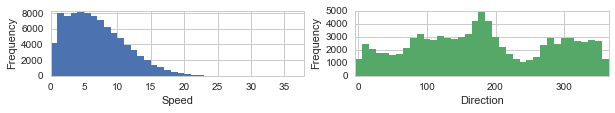

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
df['month'] = df['date']%10000//100
df['speed_origin'] = df['speed']
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date            Hr         speed           dir     speed_max  \
count  9.173800e+04  91738.000000  91738.000000  91738.000000  91738.000000   
mean   2.010121e+07     11.504785      6.836558    192.794781     12.491149   
std    3.152755e+04      6.920356      4.342434    105.274304      7.365242   
min    2.005010e+07      0.000000      0.000000      0.001183      0.000000   
25%    2.007101e+07      6.000000      3.366667    104.467773      7.000000   
50%    2.010081e+07     12.000000      6.200000    194.097755     11.000000   
75%    2.013042e+07     17.000000      9.633333    282.306477     17.000000   
max    2.015123e+07     23.000000     37.086957    359.993187     61.000000   

               HrMn         month  speed_origin  dir_windrose  
count  91738.000000  91738.000000  91738.000000  91738.000000  
mean    1150.478537      6.514727      6.836558    182.209470  
std      692.035578      3.474129      4.342434    100.197787  
min        0.000000      1.000000      0.000000      0.000402  
25%      600.000000      4.000000      3.366667    102.843687  
50%     1200.000000      7.000000      6.200000    176.166603  
75%     1700.000000     10.000000      9.633333    275.512619  
max     2300.000000     12.000000     37.086957    359.999908

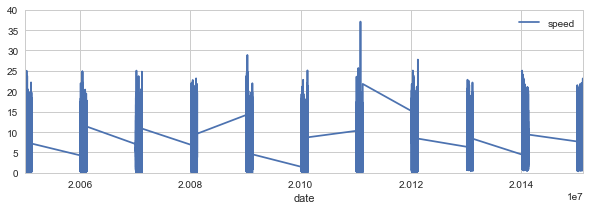

In [7]:
df.plot(x='date', y='speed',legend=True,figsize=(10,3))

### 1.2.1 Unit Detection

In [8]:
if 'knot_unit' not in globals():
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
    knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

    if knot_unit:
        df['speed'] = df['speed'] * 1.943845
        df['decimal'] = df.speed % 1
        df.decimal.hist(alpha=0.5, label='knot')
        # need more elaboration, some is not near an integer
        df['speed'] = df['speed'].apply(lambda x: int(round(x)))
    plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')

print(knot_unit)

True


### 1.2.2 Sampling Type Selection

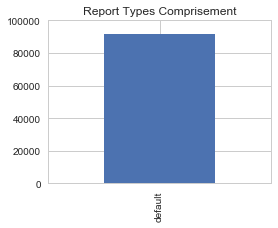

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

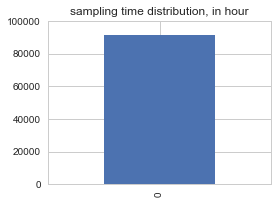

In [10]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution, in hour', figsize=(4,3))

# Need more elaboration
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)

In [11]:
df['HrMn'].value_counts().sort_index()

0       3819
100     3821
200     3818
300     3819
400     3821
500     3817
600     3819
700     3814
800     3810
900     3809
1000    3819
1100    3826
1200    3826
1300    3832
1400    3829
1500    3838
1600    3835
1700    3835
1800    3834
1900    3821
2000    3821
2100    3819
2200    3823
2300    3813
Name: HrMn, dtype: int64

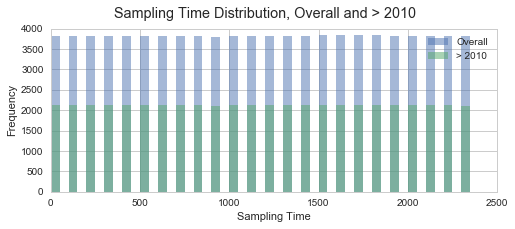

In [12]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2
bins=arange(0, 2400+100, 50)

df['HrMn'].plot(kind='hist', alpha=0.5,bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [13]:
if integer_data:
    display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
    df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

#### 1.3.1.2 sudden increase in speed

date  Hr      speed         dir  speed_max  HrMn     type  \
54519  20110818  22  37.086957   64.311729         61  2200  default   
34049  20090323  14  28.900000  277.750900         47  1400  default   
34050  20090323  15  28.116667  275.249054         50  1500  default   
66035  20121220   4  27.766667  139.180878         42   400  default   
34051  20090323  16  27.633333  277.048920         43  1600  default   
66036  20121220   5  27.350000  145.782043         40   500  default   
34046  20090323  11  26.866667  279.083374         44  1100  default   
34047  20090323  12  26.416667  279.535065         45  1200  default   
52102  20110429  14  25.700000  291.501450         42  1400  default   
34048  20090323  13  25.633333  276.649963         43  1300  default   

      wind_type  month  speed_origin  dir_windrose      incre  incre_reverse  
54519   default      8     37.086957     25.688271  28.270290      36.796634  
34049   default      3     28.900000    172.249100   3.266667       0.783333  
34050   default      3     28.116667    174.750946  -0.783333       0.483333  
66035   default     12     27.766667    310.819122   4.016667       0.416667  
34051   default      3     27.633333    172.951080  -0.483333       2.916667  
66036   default     12     27.350000    304.217957  -0.416667       1.783333  
34046   default      3     26.866667    170.916626   1.783333       0.450000  
34047   default      3     26.416667    170.464935  -0.450000       0.783333  
52102   default      4     25.700000    158.498550   0.350000       2.816667  
34048   default      3     25.633333    173.350037  -0.783333      -3.266667

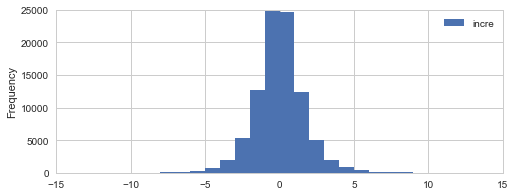

In [14]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [15]:
incre_threshold = 20 if knot_unit else 10
print('sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )')))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

sudden increase number 1


date  Hr      speed         dir  speed_max  HrMn     type  \
34049  20090323  14  28.900000  277.750900         47  1400  default   
34050  20090323  15  28.116667  275.249054         50  1500  default   
66035  20121220   4  27.766667  139.180878         42   400  default   
34051  20090323  16  27.633333  277.048920         43  1600  default   
66036  20121220   5  27.350000  145.782043         40   500  default   
34046  20090323  11  26.866667  279.083374         44  1100  default   
34047  20090323  12  26.416667  279.535065         45  1200  default   
52102  20110429  14  25.700000  291.501450         42  1400  default   
34048  20090323  13  25.633333  276.649963         43  1300  default   
66037  20121220   6  25.566667  145.682800         39   600  default   

      wind_type  month  speed_origin  dir_windrose     incre  incre_reverse  
34049   default      3     28.900000    172.249100  3.266667       0.783333  
34050   default      3     28.116667    174.750946 -0.783333       0.483333  
66035   default     12     27.766667    310.819122  4.016667       0.416667  
34051   default      3     27.633333    172.951080 -0.483333       2.916667  
66036   default     12     27.350000    304.217957 -0.416667       1.783333  
34046   default      3     26.866667    170.916626  1.783333       0.450000  
34047   default      3     26.416667    170.464935 -0.450000       0.783333  
52102   default      4     25.700000    158.498550  0.350000       2.816667  
34048   default      3     25.633333    173.350037 -0.783333      -3.266667  
66037   default     12     25.566667    304.317200 -1.783333       2.516667

### 1.3.2 0 Speed

In [16]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print(delete_zero, null_wind_frequency)

False 0.045543237734


### 1.3.3 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [17]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
try:
    SECTOR_LENGTH = 360/len(effective_column) 
except: 
    SECTOR_LENGTH = 10
print(len(effective_column), SECTOR_LENGTH)

0.001183      1
0.012245      1
0.016441      1
0.016647      1
0.017845      1
0.018738      1
0.021072      1
0.021248      1
0.021782      1
0.023010      1
0.026802      1
0.028091      1
0.029594      1
0.031273      1
0.032326      1
0.032959      1
0.033409      1
0.036667      1
0.042702      1
0.047302      1
0.047882      1
0.048141      1
0.048309      1
0.052071      1
0.056900      1
0.058914      1
0.058945      1
0.062378      1
0.064468      1
0.068649      1
             ..
359.928528    1
359.929825    1
359.930267    1
359.932327    1
359.932793    1
359.934265    1
359.936829    1
359.937881    1
359.940193    1
359.940346    1
359.942764    1
359.945145    1
359.945267    1
359.949394    1
359.950424    1
359.951698    1
359.954323    1
359.955330    1
359.957619    1
359.958000    1
359.962898    1
359.965263    1
359.965927    1
359.966705    1
359.977577    1
359.982590    1
359.987190    1
359.991882    1
359.992340    1
359.993187    1
Name: dir, dtype: int64

0 10


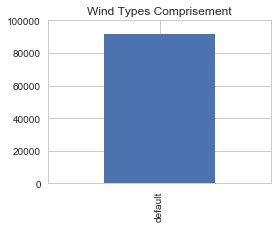

In [18]:
df=realign_direction(df, effective_column)
df=fill_direction_999(df, SECTOR_LENGTH)

### 1.3.4 Time Shift Comparison

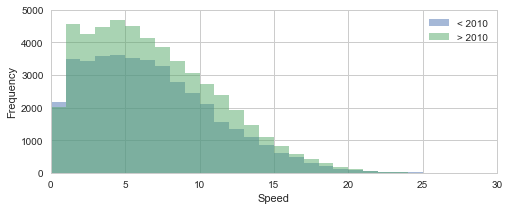

In [19]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

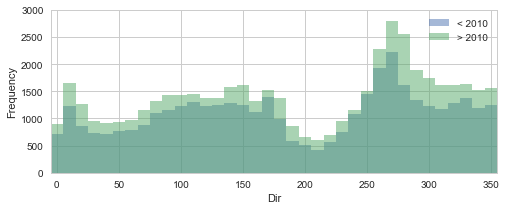

In [20]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3),tight='x')

2005 - 2009


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


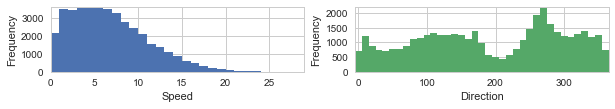

2010 - 2014


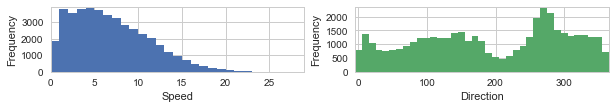

2015 - 2015


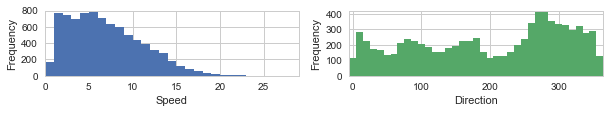

In [21]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df)

## 1.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [22]:
if integer_data:
    df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

In [23]:
if integer_data:
    if delete_zero:
        redistribute_method = 'down'
    else:
        redistribute_method = 'up'

    df, speed_redistribution_info = randomize_speed(df, redistribute_method)

## 1.5 Generate (x,y) from (speed,dir)

In [24]:
# Cook orientation
# df['dir']= (df['dir'] + 180)%360

In [25]:
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)

# 2. Re-select Data and Configs

## 2.1 Data Overview

In [26]:
## Summery of the data selection
print('Knot unit?', knot_unit)
print('Report type used:', report_type_most_used)
print('Sampling time used:', sample_times)
if 'speed_redistribution_info' in globals():
    print('Speed redistribution info:', speed_redistribution_info )

df_all_years = df # for later across-year comparison
df = df_all_years.query('(date >= 20100000) & (date < 20150000)')
# df = df.query('(HrMn == 0) and (speed >= 0.5) and (date%10000 > 900) and (date%10000 < 1000)' )
df.describe()

Knot unit? True
Report type used: default
Sampling time used: [0]


date            Hr         speed           dir     speed_max  \
count  4.273500e+04  42735.000000  42735.000000  42735.000000  42735.000000   
mean   2.012070e+07     11.505628      6.904481    192.014048     12.596981   
std    1.414591e+04      6.919849      4.377428    105.294246      7.442121   
min    2.010010e+07      0.000000      0.000000      0.001183      0.000000   
25%    2.011033e+07      6.000000      3.400000    104.102295      7.000000   
50%    2.012071e+07     12.000000      6.233333    191.463165     12.000000   
75%    2.013100e+07     17.000000      9.783333    281.607101     17.000000   
max    2.014123e+07     23.000000     27.766667    359.992340     57.000000   

               HrMn         month  speed_origin  dir_windrose         incre  \
count  42735.000000  42735.000000  42735.000000  42735.000000  42735.000000   
mean    1150.562771      6.530806      6.904481    182.388900     -0.000548   
std      691.984948      3.463356      4.377428    100.215753      1.724887   
min        0.000000      1.000000      0.000000      0.000402    -36.796634   
25%      600.000000      4.000000      3.400000    102.627228     -0.916667   
50%     1200.000000      7.000000      6.233333    175.598083     -0.016667   
75%     1700.000000     10.000000      9.783333    275.736710      0.900000   
max     2300.000000     12.000000     27.766667    359.998932     15.650000   

       incre_reverse             x             y  
count   42735.000000  42735.000000  42735.000000  
mean       -0.001007     -0.039438     -0.639733  
std         1.721075      4.786990      6.596117  
min       -28.270290    -22.615835    -24.100305  
25%        -0.900000     -2.686594     -4.660710  
50%         0.016667      0.259779     -0.184213  
75%         0.916667      2.958813      3.069497  
max        13.410714     22.819480     23.312094

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


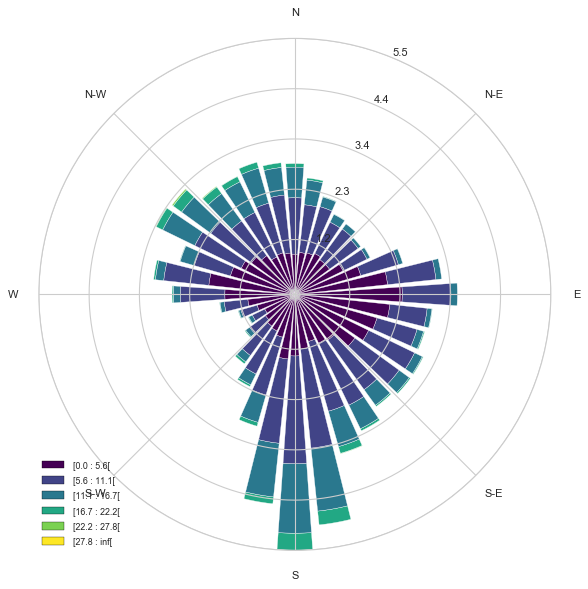

In [27]:
# 90 degree is east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

In [28]:
ax, _params = WindAxes.from_ax().pdf(df.speed, bins=arange(0, max(df.speed)))
plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF')

fig,ax = plt.subplots()
ecdf = sm.distributions.ECDF(df.speed)
x = linspace(0, df.speed.max())
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label='ECDF')

k_shape, _, lamb_scale = sp.stats.weibull_min.fit(df.speed, loc=0)
y=1-exp(-(x/lamb_scale)**k_shape) # cdf
plot(log(x), log(-log(1-y)),'-', label='Weibull')
plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'},figsize=(4,3))
align_figures()
print(k_shape, lamb_scale)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATQAAADpCAYAAACqVsvaAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAHOFJREFUeJzt3XtYVHXiP/D33BCQBEcbBmrLS7sUSpoVSb80JUERFErd
wFuxz1a7++xTWy2Wsa7bBS3Ux2Rp3cd2V13WbyZZK36B72aaSViymLpjKLpaeUNmuKgMiHP9/UGM
IBC3OZzLvF/P0/PMmXPmnDcH972fc2NUbrfbDSIiBVCLHYCIyFtYaESkGCw0IlIMFhoRKQYLjYgU
g4VGRIrBQiMixRiQQrNarZg1axbOnTvXYV51dTUWLVqEhIQELF68GLW1tQMRiYgUSPBCO3ToENLS
0vDNN990Ov/VV1/FY489huLiYsyePRtZWVlCRyIihRK80LZt24bly5fDYDB0mGe323HgwAEkJSUB
AFJSUrB3717Y7XahYxGRAmmF3sDKlSu7nHfp0iUMHjwYOp2uJYxWi6CgINTV1SE0NLTLz7lcLjgc
DqjVaqhUKq9nJiLxuN1uuFwuaLVaqNW9G3MJXmg/xOVydfp+dz+Ew+GAyWQSIhIRSURUVBT8/Px6
9RlRC02v18NqtcLhcECr1cLhcKCxsREhISE/+LnWwouIiOj1DzxQnE4nKioqEBkZCY1GI3acLskh
JzN6jxxy2mw2VFZW9np0BohcaDqdDtHR0di5cyceffRR7Ny5E9HR0Z5D0K60Hmb6+flJutCAloxS
/YcDyCMnM3qPXHIC6NPpJFHuQ8vMzMTu3bsBAMuXL8eOHTuQmJiI/Px8LFu2TIxIRKQAAzZC27Nn
j+d121szwsLCsGnTpoGKQUQKxicFiEgxWGhEpBgsNCJSDBYaESkGC42IFIOFRkSKIetCc7qcYkcg
IgmRdaFZbVaxIxCRhMi60K5cuyJ2BCKSEFkX2uVrl8WOQEQSIutCa7A1iB2BiCRE1oXGQ04iakvW
hWa9xosCRHSdrAvtio0jNCK6TtaFxosCRNSWrAut4RovChDRdfIuNF7lJKI2ZF1oV5p5Do2IrpN3
odlZaER0nbwLjSM0ImpD1oXGh9OJqC1ZFxqfFCCitlhoRKQY8i402xW43W6xYxCRRMi60BwuB5od
zWLHICKJkHWhAXz8iYiuk32h8TwaEbUSvNCKi4uRmJiI+Ph45Obmdph/7tw5LFiwAMnJyVi4cCHO
nz/fq/VfbuYIjYhaCFpoFosF2dnZyMvLQ2FhIcrLy1FSUtJumXXr1mHmzJnYsWMHpk+fjrVr1/Zq
GxyhEVErQQuttLQUEydOhF6vh06nQ0pKCoqKitot43K50NjYCABobm6Gv79/r7bBc2hE1Eor5MrN
ZjMMBoNn2mAwoLq6ut0yzz33HFJTU5GXlweHw4GtW7f2ahv1TfVwOqX3/ZytmaSYrS055GRG75FD
zv5kE7TQXC5Xh/dUKlW76ZdeegmvvfYapk2bhn/961/49a9/jYKCgg7LdeXY6WM4jMNeySsEk8kk
doQekUNOZvQeueTsLUELzWg0oqyszDNtNpthNBo903V1dTh9+jSmTZsGAJg+fTqWL1+O+vp66PX6
Hm0jaHgQxo8f793gXuB0OmEymRAVFQWNRiN2nC7JISczeo8cctpsNlRUVPTps4IWWkxMDHJyclBT
U4Pg4GAUFBQgLS3NM3/o0KEYNGgQDhw4gAceeAAHDx5EYGAghg4d2uNtNNgaJPuLAQCNRiPpfK3k
kJMZvUfKOfuTS9BCCw0NRUZGBtLT02Gz2RAbG4u4uDhkZmYiNjYWjzzyCHJzc/H666+jubkZgwcP
Rk5OTo8PNwFe5SSi6wQtNABISEhAQkJCu/eysrI8r++++27k5+f3ef28yklErfikABEphuwLjSM0
Imol/0Ljo09E9D3ZFxoPOYmolawLTQUVDzmJyEPWhRbkFwSrzQqnS7qPcRDRwJF1oQ0ZNAQADzuJ
qIWsCy1kUAgAoO5qnchJiEgKZF1oQwNaHpGqvVorchIikgJZF5o+oOUB9tomFhoRKaXQOEIjIsi8
0Ib6f3/IyREaEUHmhcYRGhG1Je9C8+c5NCK6TtaFNjSw5ZCzrpm3bRCRzAuNIzQiakvehcZzaETU
hrwLjSM0ImpD1oUW7B8MFVQcoRERAJkXmkatwdCAobDarLA5bWLHISKRybrQAGBYwDAAPOwkIgUU
Gi8MEFEr2RfasECO0IiohfwLrfWQkyM0Ip+nnELjCI3I58m/0AI5QiOiFvIvNI7QiOh7ghdacXEx
EhMTER8fj9zc3A7zzWYznn76aSQnJyM1NRXnzp3r1fo5QiOiVoIWmsViQXZ2NvLy8lBYWIjy8nKU
lJS0W2bJkiWYOnUqduzYgeTkZGRnZ/dqG7woQEStBC200tJSTJw4EXq9HjqdDikpKSgqKvLMr6ur
w/Hjx5GamgoAmDNnDl544YVebYO3bRBRK62QKzebzTAYDJ5pg8GA6upqz/TZs2cRHh6ON998E198
8QXCwsLw+9//vsfrdzqdCPFr+Sq72qZaOJ3S+cLh1ixSytQZOeRkRu+RQ87+ZBO00FwuV4f3VCqV
57XD4cDXX3+NX/3qV1i6dCny8/Px8ssvIy8vr0frr6ioQLOzGQBQ3VCNw4cPeye4F5lMJrEj9Igc
cjKj98glZ28JWmhGoxFlZWWeabPZDKPR6Jm++eabERgYiGnTpgEAkpKS8MYbb/R4/ZGRkfDz84P/
Ln9csV/BuHHj2hWmmJxOJ0wmE6KioqDRaMSO0yU55GRG75FDTpvNhoqKij59VtBCi4mJQU5ODmpq
ahAcHIyCggKkpaV55t92220ICwvDnj17EBsbi88++wyRkZE9Xr9Go4FGo8GwgGE433AeVocVIf4h
QvwofdaaUerkkJMZvUfKOfuTS9CLAqGhocjIyEB6ejqSkpIQERGBuLg4ZGZmYvfu3QCA3NxcbNy4
EUlJSdi4cSNWrFjR6+3wwgARAQKP0AAgISEBCQkJ7d7LysryvB41alSPz5l1pe2tG6Mxul/rIiL5
kv2TAgBHaETUQhGFdnPgzQAAS5NF5CREJCZFFJoxqOXKaVVDlchJiEhMiiq0i9aLIichIjF1W2hz
5871vC4tLRU0TF+FBYUBAKqsHKER+bJuC83hcHher169WtAwfRV2U0uhcYRG5Nu6LbS2d9673W5B
w/SV5xwaR2hEPq1X59Ck8ljRjUIHhwLgRQEiX9ftjbVNTU04dOgQ3G53u9etJkyYIGjAntBpdBge
OBw1TTVotDVisN9gsSMRkQi6LTS73Y4XX3zRM932tUql8jzCJLawoDDUNNXgovUiRuv5tACRL+q2
0Pbs2TMQOfot7KYwmMwmFhqRD+vRs5xutxulpaU4ceIE/P39ERERgXvvvVfobL3CCwNE1G2h1dbW
4qmnnsKZM2cwYsQIqFQq/Pe//8XYsWOxfv16BAUFDUTObnnuReOFASKf1e1VzlWrVmHcuHEoLS3F
Bx98gPz8fOzfvx8jR47EqlWrBiJjj/BpASLqdoR25MgRFBYWQq2+3n0BAQF45ZVXMG/ePEHD9Qaf
FiCibkdofn5+7cqslb+/P7Rawf+cWo/xaQEi6rbQOiszKeJFASLqdoh1+fJl7Ny5s8t5UsGLAkTU
baHdcsst2LZtW5fzpCLILwiBukBYmixwupzQqKX5BRBEJJxuC62/f+9/oKhUKoQFheFU/SmYG82e
c2pE5Du6PUFms9mwatUq/OIXv0BeXp5k/+IGwAsDRL6u20J7/fXXcfDgQYwePRpbtmzB+vXrByJX
n/DCAJFv67bQDh48iH/84x/IyMjA5s2bsWvXroHI1Se8MEDk27ottEGDBnnuNwsNDYXT6RQ8VF/x
aQEi39brm8y

1.59710756007 7.71622479979


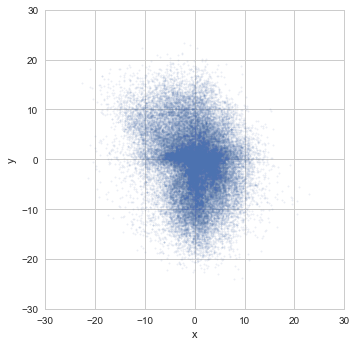

In [29]:
df.plot(kind='scatter', x='x', y='y', alpha=0.10, s=2)
plt.gca().set_aspect('equal')

## 2.2. Overview by Direction

In [30]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 10

In [31]:
original_incre, incre = SECTOR_LENGTH, rebinned_angle
start, end = -original_incre/2 + incre/2, 360

max_speed = df.speed.max()
max_count = max_count_for_angles(df, start, end, incre)
plot_range = [0, max_speed, 0, max_count*1.05]

for angle in arange(start, end, incre):
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)   
    
    fig = plt.figure()
    title ='%s (%s - %s), %s' % (angle, start_angle, end_angle, len(sub_df)) 
    sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5, label='Data')
    plt.axis(plot_range)
    plt_configure(figsize=(3,1.5), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAM0AAAB6CAYAAAAcc9ekAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAECFJREFUeJzt3X1QVNUbB/DvApIGKs6Qq1NhIghiAqsIMiSOWaIhCWhk
iMxovjGVkuVICmqCiZbOGImi+BZmypiUk+kvtYRJ0gRRA0VdXzCM14ZFlpddYJ/fH453XFmWvbK6
7PJ8Zvhjzx72Pmfx671779l7JEREYIwZzMrUBTBmbjg0jInEoWFMJA4NYyJxaBgTiUPDmEhmHZrm
5masWbMGfn5+8PPzw4YNG9Da2mq0/gCgVCoREhIChULRbp+VK1fCzc1N62fNmjXt9r9x4wZmzpwJ
Ly8vBAcHIycnp+PBduD9999vU8POnTvb7Z+Xl4ewsDB4enpi2rRp+Pvvv4Xnfv31V3z22WdPXMvP
P/+M8PDwNu1BQUFtajx+/Ljw/IkTJzBp0iR4enoiOjoaJSUlwnMajQbbt2/HG2+8AZlMhnfffRf5
+flPXGOnkBlLTk6mN998kwoKCujMmTMUEBBAW7ZsMVp/IqLExETatm2b3j4zZsyg1NRUqqysFH7q
6up09m1sbKTAwEBKSEgguVxOW7ZsoREjRtCdO3c6HrAeY8eOpaysLK0aGhoadPYtLy8nmUxGmzdv
JrlcTqtXryY/Pz+qra0V+kybNo3OnTsnuo4//viDvLy8KCwsTKtdpVLRsGHD6M8//9SqUaVSERFR
UVERvfrqq7Rv3z66fv06ffTRRxQUFETNzc1ERLR7927y9fWlEydO0O3bt2n9+vXk7e1NpaWlomvs
LLMNTVNTE3l5edHJkyeFtsOHD5O/vz+1trZ2uj8RUWVlJXl7e5NCodBbi6+vL2VnZxtUd1ZWFvn7
+5NarRbaoqKiKDk52aDf16Wuro6GDh1KcrncoP4pKSkUGhoqPNZoNDRhwgTKyMjQqjMqKkpUHcnJ
yTR8+HCaMmVKm9BcvXqV3Nzc2g1yXFwcffDBB8Lj+vp68vb2pt9++42IiKZMmUJpaWlavzNx4kTa
vXu3qBqNwWwPz65evYrGxkb4+voKbT4+Pvjvv/9w9+7dTvcHgIMHD0Imk6Fv377t1lFVVQWFQoHB
gwcbVPeFCxcgk8nQo0cPoW306NEoKCgw6Pd1kcvlsLGxgZOTk0H9CwoKMHr0aOGxRCLBqFGjtGoY
P348CgoKcO3aNYPrOHv2LPbu3YuJEye2ee7mzZsYOHAgevXqZVBNzz//PIYPH46LFy8CABISEvD2
22+3+b26ujqD6zMWsw1NRUUFevXqhd69ewttL7zwAgCgvLy80/0B4PTp0xg7dqzeOuRyOSQSCXbs
2IFx48bhrbfewq5du6DRaHT2r6ysRP/+/bXaHB0dUVFRoXc7HdVgb2+PuLg4vPbaa5g6dSqysrLa
7W9IDX379sWIESOQnZ1tcB1ZWVkYNWpUuzXa2tpi4cKFCAgIQEREhNZrV1RU6Kzp4d/G19cXAwYM
EJ47ffo07ty5A39/f4PrMxazDU1jYyOee+45rTZbW1sAgFqt7nT/1tZWXLlyBS4uLnrruHXrFqys
rODk5ITt27djzpw52LJlC9LT00XVrasGQ928eRNNTU3w9/dHeno6QkNDkZCQgKNHj3aqBhcXFxQW
Fj5xXY/XWFtbi/DwcKSnp8Pf3x8LFy7EhQsXAABNTU0Gvy9yuRzLli3DlClT4OPjY5T6xLB55ls0
kp49e7Z5Qx8+1nUIILa/QqFAa2sr+vXrJ7TNnTtX64zN0aNHERkZieDgYDg4OAAA3NzcUFtbiz17
9mD+/PkG19GzZ0+d4wwODsa///4rPNZ1GPfpp59i4cKFwmGku7s7/vnnH2RkZCA4OPiJa3BwcMCt
W7d01iXWxo0boVKpYG9vDwAYNmwYiouL8d1332HkyJHt1vT436awsBDz5s2Dq6sr1q5da5TaxDLb
0AwYMAANDQ1QKpXCH6KqqgoAIJVKO91fIpEAgNZh1tq1a9HU1CQ87t+/PyQSiRCYh1xcXFBdXY3W
1lZYW1trPSeVSoXtPlRVVaWzBgDYvn07WlpadD73kLW1dZvPXUOGDMHp06d19je0htbWVlhZGedg
pEePHlqf4x7W+PBUd3s1Pfo55/z581iwYAG8vLyQmpra7n80T5vZHp65u7ujV69eWv/z5+XlwdHR
UecHYrH9+/XrBxsbG9TU1AhtUqkUgwYNEn5sbGywdu1azJ49W+t3CwsL8corr7QJDADIZDIUFBRo
BSEvLw8ymUznOF988UWtbery4YcfYsWKFVptRUVFcHZ21tlfJpMhLy9PeExEwgmKR9XU1Aif+zor
PDwc33zzTbs1Pl5TQ0MDrly5ItRUXFyM+fPnY/To0UhLS2v3hMIz8czP1xlRYmIivf7665SXl0e5
ubkUEBCgdU2lpqaGampqDO7/uOnTp7c5zfm4s2fPkru7O6WlpVFJSQllZWWRt7c3/fTTT0RE1NLS
QpWVldTY2EhEREqlkgICAiguLo7kcjmlpqaSp6cn3b1794nfh6ysLPLw8KBDhw5RSUkJ7dmzh4YP
H07nz58nogfXSB69JlJWVkZeXl60ceNGksvl9Pnnn9OYMWPo/v37Wq8bFhZGu3btIqIH15cqKyup
paWlw3q+/vrrNqecU1JSaOTIkcJ1lk2bNmldn7p8+TJ5eHjQnj17hOs0kydPFrYXGhpKEydOpNLS
UoOuhz1NEiLTfQmts1d01Wo19u7di7Nnz6JHjx4IDAzEjBkzhEOKxMREAA9OVxrS/3GHDx/GjRs3
sGzZMr11/PXXXzh8+DDKysrQr18/hISEYMKECQAeHGIsXrwYCxYswLhx4wAAd+7cwa5du1BSUgKp
VIqoqCh4enp26r04efIkjh07hurqakilUrzzzjvCoc2VK1eQlJSE+Ph4eHh4AHiwN/z2229RUVEB
JycnzJ49W2vP1NDQgAULFmDDhg0YOHAgsrOzkZaWhs2bN3e49zl06BAKCgq0PnNoNBr8+OOPyM7O
hkKhwMsvv4yoqCi4u7sLfXJzc5GZmQmFQgFXV1fMnTsXUqkU5eXlWLJkic5tBQcHY+bMmU/8vunT
3plAk+5p8vLyTLn5DpWXl5OXlxdVVVUZ5fW6+ngfdeDAAYqOjtZqmzdvnuj3wpzG/Ch9dZvtZ5pn
QSqVIiwsDAcPHjR1Kc8UEeH7779HTEyM0HbhwgVYWVnB0dHRhJV1DRyaDixZsgS//PKL3gmblub4
8eMYOnQoxowZI7R5enpi69atJqyq6zCrU877/1essz0yyF1nuzH07t273YuElmry5MmYPHmyVpuN
jVn9U3mqeE/DmEgcGsZE4tAwJhKHhjGRODSMicShYUwkDg1jInFoGBOJQ8OYSBwaxkTi0DAmkkVM
KDLFnDTWffGehjGRODSMiaT38Ky5uRnLly/HvXv3oFarERMTAxcXF8TFxUEikcDV1RWrVq2ClZUV
MjMzceDAAdjY2CAmJgbjx49/VmNoFx+2sadBb2iOHDkCBwcHfPnll1AoFAgNDYW7uztiY2Ph5+eH
lStX4tSpU/D29kZGRgZ++OEHqFQqREZGIiAgQLgZH2OWRG9oJk2ahKCgIAAPvgJrbW2NoqIi4X7I
gYGBOHPmDKysrCCTyWBrawtbW1s4OTmhuLjYoJtFiLm5xr//1hrcV/82643yOk+2bRMtD2FCljZm
vaGxs7MD8GCNlkWLFiE2Nhbr168XbqRnZ2eHuro6KJVKrXsk29nZQalUGlRAu3f80OFate7DLbFG
jTLN4Vl+fr6o8VoCcx2zvqB3eCKgrKwM0dHRmDp1KkJCQrRud1RfX48+ffrA3t4e9fX1Wu2Phogx
S6I3NNXV1Zg

## 2.3 Overview by Month

In [32]:
month_incre = 1
current_df = df.query('speed>=1')
for month in arange(1, 12+month_incre, month_incre): 
    end_month = month+month_incre
    sub_df = current_df.query('(month >= @month) and (month < @end_month)')
    if len(sub_df) > 0:
        if month_incre == 1:
            title = 'Month: %s' % (month)
        else:
            title = 'Month: %s - %s ' % (month, end_month-1)
        ax = WindroseAxes.from_ax()
        ax.bar(sub_df.dir_windrose, sub_df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=plt.get_cmap('viridis'))
        plt_configure(figsize=(3,3), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOwAAADxCAYAAADIm1tRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAIABJREFUeJzsnXd4W+XVwH+almTZsixL3jN27MTOhoQMsiAkJUBogLIp
LXQySmkLdNAUaIG2fOwWWiCspmUUaBJWyCQJZO94721Z1rA1rXW/P4xkjJ3ESWTHAf+ex89j33t1
76vre+4571mvSBAEgVFGGeWsQHymBzDKKKMMnlGBHWWUs4hRgR1llLOIUYEdZZSziFGBHWWUs4hR
gR1llLOIUYH9BjAaufv6MCqww8DChQvJz8/n0UcfHXB/c3Mz+fn55OfnY7FYInrtDRs2sGLFivDf
zzzzDFOmTInoNRwOBwsWLODjjz+O6HlH6c+owA4TIpGI9evXD7hv3bp1Q3bdV199FaPROGTndzgc
/PSnP6WlpWXIrjFKL6MCO0xMmTKFpqYmSkpK+u37+OOPyc/PPwOjOj12797NVVddRVlZ2ZkeyjeG
UYEdJsaNG0d6eno/bdrS0sKRI0dYsmRJv8+sX7+eK664gsmTJzNv3jyefPJJ/H5/eP/ChQt54YUX
WLFiBdOnT2fq1Knce++9OBwOAG688UZ2797Nli1byM/Pp6mpKfzZDz/8kMWLFzNhwgSWL1/O/v37
w/uamprIz8/nmWeeOe53uu222xg7diwvvvjiKd2TUU6eUYEdRi666KJ+ZvG6deuYNGkSSUlJfba/
+eab3H777UycOJFnn32WG264gZUrV3Lffff1Oe4f//gHXV1dPP7449x111188MEHPPfccwCsWLGC
8ePHM3XqVN58800MBgMAbrebJ554gjvvvJOnnnoKt9vNHXfcEX4ZGAwG3nzzTa666qrjfp9Vq1bx
1FNPER8ff1r3ZZTBIz3TA/gmsWTJEl566SWqq6sZM2YM0GMOf+tb3+pzXCAQ4Mknn2Tp0qVhh9Gc
OXOIiYlhxYoV3HrrrRQUFACQlJTE448/jkgkYs6cOXz66ae8+OKLTJ8+nXnz5qFWq1GpVNx99928
9tprQI/X+K9//SuTJ08GwO/3c8cdd1BVVUVBQQFyuTy873iMHTs2YvdmlMExqmGHkQkTJpCcnMwn
n3wCQGtrK4cPH2bx4sV9jqupqcFisfQzk5cuXQrA3r17+5xTJBKF/9br9UCPdrXb7QOOQyKRMHHi
xPDfqampAMc8fpSRw6jADiMikaiPWbxu3TomTpxIcnJyn+M6OzsB0Ol0fbbHxMQgl8vDc1QApVLZ
7xoSiYQ5c+bwyCOPDDiOqKgoxOLef33o92AweIrfbJThYlRgh5mLLrqI4uJimpqaWLduXT9zGCAu
Lg4As9ncZ3tXVxderze8/3jcd9997NixA5vNFpmBjzIiGBXYYWbq1Kno9XreeOMNDh061M8cBsjO
zkar1fZLRPjwww/D5zgRarWahx56iLq6uj6e5VHObkadTsOMWCxm0aJFvPLKK+E57VeRSCTcfvvt
PPTQQ2g0Gi644ALKy8t55plnWLJkyaCdPXPmzEGv13PgwAGUSiXd3d2D+pzX66WkpISkpKR+3utR
ziyjGvYMcNFFF+Hz+QaMvYa44YYb+NOf/sSuXbv48Y9/zKpVq/je977HY489dlLXevDBB3G73XR0
dFBVVTWoz7S3t3P11Vfz9ttvn9S1Rhl6RKM9nb5eNDU1cdNNN7Fp06bwtu3bt3PLLbewceNG0tLS
zuDoRjldRgV2lFHOIkZN4lFGOYsYFdhRRjmLGBXYUUY5ixgV2K8BwWAQn8+H1+vF6/XS3d2Nx+PB
4/HQ3d2N1+vF5/Ph9/tHRPeJTZs2sXz5cpYsWcIf//jHYx5XUlJCUVHRMI5s5DMahx3BCIIQFkSf
zxf++aoQnmxKoUQiQSaTIZPJkMvlyOXy8N8ymYyoqCik0qF5NBobG1mxYgVvv/02Op2O7373u2zZ
soX58+f3Oc7tdvPggw/i8/mGZBxnK6MCO0IQBAGv14vL5cLpdOJ0OnG5XASDQcRicfhHKpUilUpR
KpVoNBqioqLCQhcSMrFYTCAQ4ODBg0yePBmRSIQgCPj9/rAGDgl96JohwQ8GgwiCgEwmQ6VShat9
VCpVRIR4/fr1XHzxxeGEjCeeeAK5XN7vuEcffZSbb76ZAwcOnPY1v06MCuwZwu/3Y7fb+wmnVCpF
JpOhVCrR6XRoNBpkMtlpXSuU3C+RSIiKiiImJuaYxwqCgNvtprOzE6fTSUdHBz6fj2Aw2EeIo6Oj
UavVfSqFBkN9fT1yuZxbbrmF9vZ2Fi5cyF133dXnmI0bN+LxeI6bWPJNZVRgh5Hu7m5sNhtWqxWn
0xk2TVUqFXq9Ho1Gg0QiOaNjFIlEYY36ZbxeL1arla6uLkwmEy0tLYhEIjQaDXFxcYMeeyAQYNu2
baxatYro6Gh++tOf8t5777F8+XIATCYTzz33HK+88spQfL2znlGBHUIEQcDlcmG1WrHZbHR3dyOT
yVCr1aSmph5X04005HI5iYmJJCYmAj2OLovFgtlspqGhgUAgQHR0NPHx8WFTfSASEhKYOXNmuHTw
ggsu4PDhw2GB3bJlCzabjeuvvz78mWXLlvH6668TGxs7xN9y5DMqsBFGEISwKWmz2QgGg0RFRREX
F0diYuJpm7cjBbFYTEJCAgkJCQA4nU7a29tpa2ujsbGRqKgotFoter2+zxx1wYIF3HPPPXR2dqJW
q9m+fTsLFy4M77/qqqv6tKbJz89n9erVw/fFRjijAhshAoEAVqsVo9FId3c3UVFRJCUlYTAY+hSL
f12Jjo4mOzsb6DH9jUYjZrOZtrY2NBoNBoOBmJgYJk2axA9+8AOuv/56fD4fM2fOZPny5fz2t79l
4cKFXHDBBWf4m4xsRnOJTxOPx0N7ezsdHR2IxWLi4uJITU0945r0y17iMzkvdjgcNDc343Q6kUql
JCYmotPphixs9HVn9K6dAoIgYLPZMBqNOJ1OFAoFmZmZxMfHn7TX9OuOWq0mPz+fQCBAa2srbW1t
NDc3Ex8fj8Fg6OfcGuX4jGrYk0AQBCwWC83NzQQCAdRqNenp6SgUijM9tH6MFA07EFarlZaWFjwe
D2q1mrS0NKKjo8/0sM4KRjXsIBAEga6uLhobG/H5fGi1WtLT00ecIJwtaLVatFotbreb+vp6ysrK
wlOJkfjyG0mMCuwJcDgcNDY24na7iYuLIzMzc1RQI4RSqaSgoAC3201tbS3FxcXodDpSUlIGzH4a
ZVRgj4nb7aapqQm73U5MTAwTJkw4446krytKpZLx48fjcDioq6vj6NGjGAwGkpKSRp1TX2H0bnwF
v99PY2MjFosFlUrFuHHj+vX+HWVoUKvVFBUVYbFYaGpqwmQykZycTGJi4qgz7wtGBfZLWK1W6uvr
EYvF5OXljWbWnCHi4+OJj4+npaWF1tZWLBYLOTk5o/NbRgUW6NGq9fX1dHZ2otfrSU1N/UYkO4x0
UlJSMBgMVFVVUVJSQkpKyjde237jBdZqtVJXV4dMJhs1fyPI3XffTXFxcVgr3n777SxatKjfcU8/
/TQikYg77rhjwPNIpVIKCgro6OgIT1W+ydr2GyuwX9aqiYmJpKSkfKPf3JHm6NGjvPXWW8dcVqSr
q4tHHnmEDz/8kFtvvfWE50tISECr1X7jte2IsftCiwh/+umnfbYvXLiwz0LEPp+PKVOmYLFYwttu
vPFGrrjiivDfnZ2dTJkyBa/XO+C1rFYrR48exeVyMW7cOFJTU8/qf3yoRYzb7Q7X1zqdToDw7x6P
Z9haxFitViwWC/fccw+XXnopzz77bL/rrl+/nuzsbL73ve8N+rwSiYT8/HwyMjJobW2ltLQUj8dz
ws8N9tkCePf

## 2.4 Month Accumulation

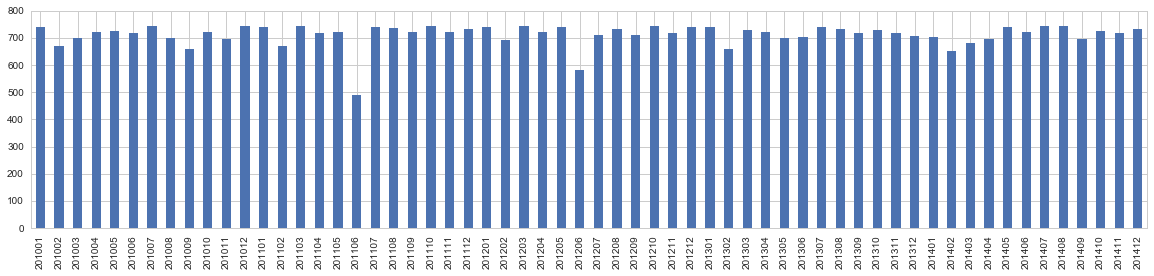

In [33]:
df['date'].apply(lambda x: str(x)[:-2]).value_counts().sort_index().plot(kind='bar', figsize=(20,4))

## 2.5 Create input data, i.e. speed_set

In [34]:
SPEED_SET = array(list(zip(df.x, df.y)))
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [35]:
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1
   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16]


In [36]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 3. Kernel Density Estimation

In [37]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [38]:
%%time
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV  ## too slow

# The bandwidth value sometimes would be too radical
if knot_unit:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(sample) > 50000:    
    df_resample=df.sample(n=50000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = sample

grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                    {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
print(bandwidth)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.9
Wall time: 2min 40s


In [39]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth,kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print('bandwidth:', bandwidth, len(kde_result))
print(kde_result[:5])

bandwidth: 0.9 1089
[  2.57025516e-07   8.48563992e-07   1.14278152e-06   3.13321497e-06
   8.40638010e-06]


In [40]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x', ylabel='y',ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmQM2d9Lvp0t/ZtZjTbN/v22cFAEmwM3BQEKg7EiW8S
QkgFyFJZyKmTuokJOdwCsxingA8MIU6qQo5PcEI4ZbtiU9ThEidU3QJC4gNJAMc4N3gBPDPfjDQa
aWakGe3qVi/3D837ztutbqlbas1I436qXJ5vpvvtV1L3o9/6/DhN0zR48ODBwyUFf9Eb8ODBg4dB
wiM5Dx48XGp4JOfBg4dLDY/kPHjwcKnhkZwHDx4uNTyS8+DBw6WGR3IePHi41PBIzoMHD5caHsl5
8ODhUsMjOQ8ePFxqeCTnwYOHSw2P5Dx48HCp4ZGcBw8eLjU8kvPgwcOlhkdyHjx4uNTwSM6DBw+X
Gh7JefDg4VLDIzkPHjxcangk58GDh0sNj+Q8ePBwqeGRnAcPHi41PJLz4MHDpYZHch48eLjU8EjO
gwcPlxoeyXnw4OFSw3fRG/Bw8dA0DZIkQZZlCIIAv98PnufBcdxFb82Dh77BaZqmXfQmPFwcRFFE
sVhEPB5Hs9kEAGQyGUxMTCAej4PneY/0PIw0PEvuBQxFUVCv13F4eIhoNApZluH3+6FpGjRNg6Io
kGUZkiSB4zgIguCRnoeRg0dyL0BomgZZlqEoCjiOg6Io2NzchKIo8Pl8UFUVtVoNwWAQPt/ZLUJI
TxRF8DwPQRAgCAJ8Pp9Heh6GFp67+gKDqqpoNpsgH/v+/j4KhQKWl5cRCAQgSRKy2Sw4jkOz2YTP
50MkEkE4HEYkEoEgCLr1yDocx1Gy8/l8bcd58HBR8Cy5FwiI+6koCgBAlmWk02moqgq/3494PA5J
khAKheD3+zE2NoZoNApRFFGr1VAsFpHL5SjpEeJjyUyWZWiaBlEUcXBwgNnZWQQCAY/0PFwoPJJ7
AUBVVciyDFVVwXEcyuUy9vb2kEwmkUgksLu7qzue4zhomgaO4xAKhRAKhZBMJqFpGhqNBur1Ok5O
TpDNZuH3+ynhsaRXrVYhSRIlPeLeepaeh/OGR3KXHCSORpIJ2WwWpVIJS0tL1FKzG7HgOI6SGUt6
tVoNJycn2N/fRyAQQCQSgaZplFSBszigR3oezhseyV1SqKoKRVGgqioAQJIkpFIpBAIBbGxs0IRC
P8kClvTINYmlp6oqUqkUgsEgjeeFw2HwfKv+3CM9D+cFj+QuIVRVxdHREYrFIpaXl3F8fIxsNouZ
mRkkk8k2YjNacsRddQqe52m8rlQqYW5ujmZqC4UCGo0GgsGgzr3tRHqVSgWJRALBYNAjPQ89wyO5
SwbingIt4kin06jX61hbW0MoFGo7fpBlHzzPIxQKIRKJAGiRb71eR71eRz6fhyiKCIVC1NILhUI6
0js4OIDP54Msy56l56FneCR3SWCsfWs2m6hUKhgfH8fGxgYlD6tzgcESHtAivWg0img0CuCM9Gq1
Go6OjijpEUuPJD+IZWnl3gYCAa9Gz4MlPJK7BDDWvh0dHeHg4ACBQAALCwsdzzUjh17dVacwkh7p
wCBdGLIsI5vNIhqNUkuvWyKD9N56pOeBwCO5EQex3oAWSezt7UGWZVy5cgWlUsnWGsNSDy4IAmKx
GGKxGABga2sLiUQCkiTh4OAAzWZTZ+mZkV6z2USj0aCkx3Ec/H6/596+gOGR3IjC6J5WKhWk02mM
j49jeXkZ1WrVFnlZWTxuEF+/a3Ach0gkgvHxcQBnll6tVkMul4Msy5T0IpEIgsFgG+nt7+/TNTxL
74UJj+RGEGztGwDkcjkcHx9jYWEB8XicHtcrybhBAIMgEaOlJ8syJb1sNgtZlnXlKsFgkO7FytLz
SO/ywyO5EYKmacjn8/D7/QiFQmg2m0in0+A4DhsbG/D7/fRYuw/tecXfBgGfz4d4PE6JnSW9k5MT
KIpCEy7BYFCXoGBJj8T0CPF5pHe54JHciIC0Zh0fH9M41d7eHqampjA1NdX2UPZLXqNIfGakl8lk
6P8VRdGJDbCkp6oqTeCwpOfz+eDz+TzSG2F4JDcCUBSFCloCwPHxMSRJwsrKCq1B6xVsnyr7u8sA
QlCE+JrNps7SU1WVEl4kEtFZcCzpNZtNlMtlzM7OeqQ3gvBIbohhTC40Gg1UKhUEg0FcvXq1Y8Zw
lN3QQcHv98Pv9yORSAAAms0marUa6vU6CoUCNE3TWXqE9GRZRq1Wo+4tx3GepTdC8EhuSMEqhwBA
oVBALpdDKBTC2NhY15IIuyTHxqicnjvqIJJSY2Nj0DRNZ+kVCgUAQDgcpkKirMXLWnoe6Q03PJIb
QrC1b6qqIpPJoNFoYG1tjT58LwS4VcZih3A4jkMgEEAgENCRXq1WQ7lchiiK2N7eNrX0AI/0hhke
yQ0RjO5prVZDKpVCPB6nrVlOLDQnEkqDsNzcWPOiyIElPb/fj0KhgNnZWdRqNVSrVRwdHYHneV3J
ihXpAa3yF1LMzNbzeRg8PJIbEhhr3w4PD3F0dIT5+XmMjY31tGY/dXJuFPJeFmiaRntkA4EAxsfH
6RjHWq2GSqWCg4MDCIKgS2SwFpyqqjg4OEA0GkU8HtcNBSKdGR4GA4/kLhiapqFarWJ/fx/Ly8tQ
FIXKkm9sbCAQCOiOdxprs4PLHIOz6646BcdxCAaDCAaDmJiY0JFeuVympMdKxbOCA2aWHhkK5JGe
u/BI7gJBkgtkAhaRJZ+YmMDMzExfzfOXmbjOG3aI0oz0RFFEvV5HqVRCLpejasnAWULD6N5KkgQA
bUOBPNLrHR7JXRBY95RII+3t7WFxcZG2LZnBCXk5IbmjoyOUSiWEQiE6mtBDC718WbDzMQjp7e7u
wufztQ0FYiehETIjQ4eMM2890nMO704+Z5jpvqXTaWiahqtXr9oiFzfdVVKmUi6XMTMzQ0soKpUK
6vW6zt3qpEk3rHDLXe13DZJxTSQSdAYGkYovFovIZrMIBAK6RIYV6e3v72Nubk43Cc0jPWt4JHeO
ME7NKhaLyGQySCaTdMZpN7jZk0qytxzHYXl5mc5sIG5VLBYzlS43qvhedgwirudkKBA7CY3jONTr
ddoF41l63eGR3DmBrX3TNA2ZTAbVahWrq6u0RMEO3Ii1kUb/w8NDLCwsIJPJmLZ1kYdrcnJSp+J7
eHgISZJ0mUSzsggvJqhHJ7LsNBTo+PgY+/v7dCgQKUwm5wGee9sJHskNGGatWalUCuFwGBsbGxAE
AYqiuF7TZnWcLMtUWJNkbzOZTFdrxUrF10zmiLhjw4DzLCh2cx12KBD5kiGWnqZpuH79uulQIJb0
ZFn2SA8eyQ0Uxsb6fD6Pg4MDXLlyBRMTE/T3gyjcNTuOuKeJRAJLS0vU3ezlhjfTdqvVaqjVajg+
PoYsy8jn84jH47Q7wCncIspheaD7IUuW9AqFAtbX1yGKImq1WtehQIA56YmiiFgsduk7MjySGwA0
TYOiKHj66adx9epVAEAmk4EkSVhfX6dijgROXVCnD7/RPSUN6sZjyI3ei0vs8/mQSCSQSCSgaRp2
dnYQDAbpkBrykJKHcJSyt4OqtesF5HNhSQ+wHgrUifSuX7+OlZUVWpBMipNZi/AyYHTutBGBsbG+
Wq0im80ikUhgcXGx69QsO/VYdkCOM3NPe13TLkgmMRaL0USGsVCWlE+wmcROr6NXDIvbDLhDlmxB
MYtOk9BIDJWVig+FQtA0jb7vZpYeKU4eddLzSM5FGFuzSHO9lfVEQG5auyTn5MHd3NxEPB7Xuadm
MK7pJjmYFcoaM4mDzNy6RSz9wk2S64ZOk9AODg4gSRI0TcPx8XHbJDRyvCzLbVLxo0h6Hsm5AOKe
yrJM9cdI7dv

In [41]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM by Expectation-maximization

In [42]:
sample= SPEED_SET
clf = mixture.GaussianMixture(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print(clf.converged_)

True


In [43]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.492   1.111  -0.088  3.758  2.758  -0.007
2  0.261   0.992  -8.551  4.245  4.239   0.092
3  0.246  -3.432   6.642  5.513  4.728   0.052

GMM Plot Result
0.492464016294 [[ 1.11084428 -0.08772302]] [ 2.75742401  3.75834963] -90.6098382177
0.261144532062 [[ 0.99216178 -8.55125469]] [ 4.04266087  4.4329859 ] -45.4196074794
0.246391451644 [[-3.43188289  6.64219954]] [ 4.70498589  5.53251614] -80.7323663805


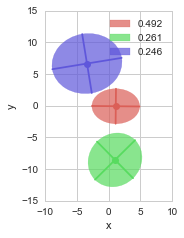

In [44]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax)

In [45]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points))
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvWmQLGd1Lbqy5qG7eh5Oz8NhEJIQOgi4YSwUlq0LV5YD
uIBt+REGWX7Gvn7YDzwgEAIukrDwAO8GxrLBz8ZheBYyYTCEsMNhLMCADMi6ChsJCE7PVd01D13z
kJnvR5399VdZOVZld1cd5YpQHJ0+WV9mVWeu2t/ea68tyLIsw4EDBw6uUrjO+wIcOHDg4DThkJwD
Bw6uajgk58CBg6saDsk5cODgqoZDcg4cOLiq4ZCcAwcOrmo4JOfAgYOrGg7JOXDg4KqGQ3IOHDi4
quGQnAMHDq5qOCTnwIGDqxoOyTlw4OCqhkNyDhw4uKrhkJwDBw6uajgk58CBg6saDsk5cODgqoZD
cg4cOLiq4ZCcAwcOrmo4JOfAgYOrGg7JOXDg4KqGQ3IOHDi4quGQnAMHDq5qOCTnwIGDqxoOyTlw
4OCqhkNyDhw4uKrhOe8LcHD+kGUZjUYDrVYLbrcbXq8XLpcLgiCc96U5cNA3BFmW5fO+CAfnh3q9
jkKhgNHRUTSbTQDA4eEhJiYmMDo6CpfL5ZCeg6GGE8k9hyGKIqrVKlKpFMLhMFqtFrxeL2RZhizL
EEURrVYLjUYDgiDA7XY7pOdg6OCQ3HMQsiyj1WpBFEUIggBRFLG1tQVRFOHxeCBJEiqVCvx+Pzye
k1uESK9er8PlcsHtdsPtdsPj8Tik52Bg4WxXn2OQJAnNZhP0az86OkI2m8XKygp8Ph8ajQbi8TgE
QUCz2YTH40EoFEIwGEQoFILb7e5Yj9YRBIGRncfj6TrOgYPzghPJPUdA209RFAEArVYL0WgUkiTB
6/VidHQUjUYDgUAAXq8XY2NjCIfDqNfrqFQqKBQKSCQSjPSI+Hgya7VakGUZ9XodyWQSc3Nz8Pl8
Duk5OFc4JPccgCRJaLVakCQJgiCgWCwiFothcnISkUgE+/v7HccLggBZliEIAgKBAAKBACYnJyHL
Mmq1GqrVKvL5POLxOLxeLyM8nvTK5TIajQYjPdreOpGeg7OGQ3JXOSiPRsWEeDyO4+NjLC8vs0jN
bMZCEARGZjzpVSoV5PN5HB0dwefzIRQKQZZlRqrASR7QIT0HZw2H5K5SSJIEURQhSRIAoNFo4ODg
AD6fD5ubm6yg0E+xgCc9OidFepIk4eDgAH6/n+XzgsEgXK62/twhPQdnBYfkrkJIkoR0Oo1CoYCV
lRXkcjnE43HMzs5icnKyi9iUkRxtV63C5XKxfN3x8TEuXLjAKrXZbBa1Wg1+v79je6tHeqVSCZFI
BH6/3yE9Bz3DIbmrDLQ9BdrEEY1GUa1Wsb6+jkAg0HX8aco+XC4XAoEAQqEQgDb5VqtVVKtVZDIZ
1Ot1BAIBFukFAoEO0ksmk/B4PGi1Wk6k56BnOCR3lUCpfWs2myiVShgfH8fm5iYjD63XAqdLeECb
9MLhMMLhMIAT0qtUKkin04z0KNKj4gdFllrbW5/P52j0HGjCIbmrAErtWzqdRjKZhM/nw+Liou5r
1cih1+2qVShJjzowqAuj1WohHo8jHA6zSM+okEG9tw7pOSA4JDfkoOgNaJNELBZDq9XC/Pw8jo+P
Ta0xKHpwt9uNkZERjIyMAAC2t7cRiUTQaDSQTCbRbDY7Ij010ms2m6jVaoz0BEGA1+t1trfPYTgk
N6RQbk9LpRKi0SjGx8exsrKCcrlsiry0Ih47iK/fNQRBQCgUwvj4OICTSK9SqSCRSKDVajHSC4VC
8Pv9XaR3dHTE1nAivecmHJIbQvDaNwBIJBLI5XJYXFzE6OgoO65XkrGDAE6DRJSRXqvVYqQXj8fR
arU65Cp+v59di1ak55De1Q+H5IYIsiwjk8nA6/UiEAig2WwiGo1CEARsbm7C6/WyY80+tGeVfzsN
eDwejI6OMmLnSS+fz0MURVZw8fv9HQUKnvQop0fE55De1QWH5IYE1JqVy+VYnioWi2F6ehrT09Nd
D2W/5DWMxKdGeoeHh+xPURQ7zAZ40pMkiRVweNLzeDzweDwO6Q0xHJIbAoiiyAwtASCXy6HRaGB1
dZVp0HoFkWG5XEahUGDdC1cDiKCI+JrNZkekJ0kSI7xQKNQRwfGk12w2USwWMTc355DeEMIhuQGG
srhQq9VQKpXg9/tx8eJF3Yqh2UiOjolGo4hEIsjn86hUKvB4PBBFsaszYZjh9Xrh9XoRiUQAAM1m
E5VKBdVqFdlsFrIsd0R6RHqtVguVSoVtbwVBcCK9IYJDcgMK3jkEALLZLBKJBAKBAMbGxgwlEWZI
rtls4uDgAACwsbHBfp5MJtl5+c4Einh46cYwgyylxsbGIMtyR6SXzWYBAMFgkBmJkjgZ6Iz0HNIb
bDgkN4DgtW+SJOHw8BC1Wg3r6+vs4esXvN1SpVKB1+tlW2JBEODz+TA5OcmugR5+pV5NKd2wE3bJ
WMxcG71nn8/XQXqVSgXFYhH1eh07OzuqkR7gkN4gwyG5AYJye1qpVHBwcIDR0VHWmmV2G6p1nCzL
SCQSyOfzWFpawsjICFKplO6aap0JtM1TSjcooU/n6hfnRQ486Xm9XmSzWczNzaFSqaBcLiOdTsPl
cnVIVrRID2jLX+jL4bS+FByowyG5AYFS+5ZKpZBOp7GwsICxsbGe1lSSDG1PXS4XLl682DG/gYcR
kbrd7q4qZqVS6Ujoy7KMUqnEBt8M80MtyzLrkfX5fBgfH2djHCuVCkqlEpLJJNxudwfZ8xGcJElI
JpMIh8MYHR3tGApEnRkOTgcOyZ0zqLJ5dHSElZUViKLIbMk3NzdZVESwEsnxoO3p1NRUl+SkX7mJ
x+NBJBLpSOgfHBygVquhUCiwzgU+4jkrmN2uWoUgCPD7/fD7/ZiYmOggvWKxyEiPf9+84YBapEdD
gRzSsxcOyZ0jqLhAE7CIiCYmJjA7O9tX8zwdR9vTQqHA3IBPGxSdTE9Pw+/3s9wWH/HwD79WRDko
MEOUaqRXr9dRrVZxfHyMRCLB3JKBk4KGcnvbaDQAoGsokEN6vWOw766rGPz2lKyRYrEYy5NpwUrU
JUkStre34Xa7O9yAtdZU/mkH+NyWcptHD7/ecJxBQC+fBT8fg0hvf38fHo+naygQPwmNyIyGDiln
3jqkZx0OyZ0x1HzfotEoZFnWzZMp1zBCqVSCJEmIRCKqHRHnBbWIhx+Ow8+JoOimH9i1Xe13Daq4
RiIRNgOD3nehUEA8HofP5+soZGiR3tHRES5cuNAxCW1Qfr+DCIfkzhDKqVmFQgGHh4eYnJxkM06N
YHQzS5LEtqeCIGBmZsbUtZ1XG5dyOA7NiahUKpAkCfv7+5ruwWeF08jrWRkKxE9CEwQB1WqVdcE4
kZ4xHJI7I/DaN1mWcXh4iHK5jLW1NSZRMAO9rSQNq/F4PNjY2MDly5dNr6n8e78RFNAbcSrnRCwu
LrLqbSqVQqPR6Ih2hkmYrEeWekOBcrkcjo6O2FAgql7T6wBne6sHh+ROGWqtWQcHBwgGg9jc3ITb
7YYoipbGAqodS1HhzMwMpqamWNHBynUO4oOg5R7Me8opNXr8+zhLQbGd6/BkPzU11RHhyrKM3d1d
1aFAPOm1Wi2H9OCQ3KlC2VifyWSQTCYxPz+PiYkJ9nMriX7lsZIkIR6Po1gsdjXsW1nTbthFCkro
ecqpNd0PEnn3cy086WWzWWxsbKBer6NSqRgOBQLUSa9er2NkZOSq78hwSO4UIMsyRFHEM888g4sX
LwIADg8P0Wg0sLGxwcwcCVarmXRsvV5ns1SNGvbNrEk3+jB5zCntlZRN961WC5lMBqOjo6wVyyoG
jSiBTtIDtIc

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADSCAYAAABdE+UBAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAG91JREFUeJzt3XtQVOfdB/DvsssakYtDvYSoGNGEF0m8oImTKdoZoqXx
NU1TBvG2mSZMMp1pTdOqpRgREkFtU513Rq0dncm04j3mD5upU8dKGuqliWjBARS1GBSNaLzERSkL
u+f9g5zD7rq75+xyds85u9/PTGaEc3s2cL48zznPOT+TIAgCiIhkxGndACIyBoYFESnCsCAiRRgW
RKQIw4KIFGFYEJEiDAsig3C5XFi9ejWKiopgs9nQ1tbmsbympgYFBQUoKirC/v37PZY1NDTAZrNJ
X587dw6LFi2CzWZDcXExvv76a/kGCERkCIcPHxZKSkoEQRCEf//738JPf/pTaZnD4RBmz54t3Lt3
T+ju7hZ+/OMfC7du3RIEQRC2bdsmzJs3TygsLJTWX7x4sdDc3CwIgiDs2bNHWLt2rezx2bMgMojT
p09j5syZAIApU6agsbFRWvaf//wH6enpSElJgdVqxbRp03Dq1CkAQHp6OjZt2uSxr40bNyIrKwsA
4HQ6MWjQINnjW9T6IJF0+vRprZtAJJk2bZridf9dfxQu51C/y61WK5599lmfyzo7O5GYmCh9bTab
0dvbC4vFgs7OTiQlJUnLhgwZgs7OTgBAfn4+2tvbPfY1YsQIAMCZM2ewc+dO7Nq1S7bthgwLANi/
9p+aHNdut3v8UIyMn2Xg5q+cGdT6LudQDB+zzu/yW1dL/S5LTEzEgwcP+vflcsFisfhc9uDBA9n/
H4cOHcLWrVuxbds2pKamyrZdk2GI+8WW5uZmzJw5EzabDTabDYcOHdKiSUS6l5OTg9raWgBAfX09
nn76aWnZ+PHj0dbWhnv37sHhcKCurg5Tp071u6+DBw9i586dqK6uxpgxYxQdP+I9i+3bt+Mvf/kL
Bg8eDABoamrC66+/jjfeeCPSTSEylDlz5uD48eNYsGABBEHA2rVr8cknn+Dhw4coKirCb37zGxQX
F0MQBBQUFGDkyJE+9+N0OlFVVYW0tDQsXboUAPDcc8/h7bffDnj8iIeFeLHl17/+NQCgsbERly9f
xtGjRzF27FisXLnSY1xGRH3i4uLw/vvve3xv/Pjx0r/z8vKQl5fnc9vRo0dLt1PNZjO++OKLoI8f
8bDwvtgyadIkFBYW4plnnsHWrVuxZcsWlJSUyO7HbreHs5m6Pbba+FlIKc0vcM6ZMwfJycnSv9es
WaNoO60uzPGioD5F02fRK83nWRQXF+Ps2bMAgJMnTyI7O1vjFhGRL5r3LCoqKrBmzRrEx8dj2LBh
insWRBRZmoSF+8WW7Oxs7N27V4tmEFEQNB+GEJExMCyISBGGBREpwrAgIkUYFkSkCMOCiBRhWBCR
IgwLIlKEYUFEijAsiEgRzZ8NIYo1HV2tfpfp+a83w4Iowlpc+X6XZUWwHcHSc5ARkY4wLIhIEYYF
kUGoWb6wra0NCxcuxKJFi1BeXg6XyyV7fIYFkUH8/e9/h8PhwL59+7Bs2TKsX79eWtbT04N169bh
ww8/RHV1Nfbt2yfVL92+fTtWrVqF7u5uaf1169bhnXfewe7duyEIAo4ePSp7fIYFkUGoWb6wqakJ
zz//PABg1qxZOHHihOzxGRZEBuGvfKG4LFD5QrFymUgQBJhMJmldJW9G17wiWShjJ6JYpGb5wri4
OI91xTfsBxLxsPAeP4UydiKKRWqWL5w4cSI+//xzAEBtbS2mT58ue3zNK5J5j52OHz+OOXPmyO6H
RYbUwc9iHGqVLwSAkpISlJWVYePGjcjIyEB+vv+JYiLNK5KFMnYCWGRIDfwsxqJW+UIAGDduHHbu
3Bnc8YNaOwxCGTsRUeRpHhahjJ2IKPI0D4uSkhJs2rQJRUVF6OnpUTR2IqLI07wiWShjJyKKPM17
FkRkDAwLIlKEL7+JUi33u2XX6XXGwfLtepnJg8LdJDI4hkWUcQ+JjGdGB1xXnJvQ2tjusR2Dg3xh
WEQR8YSXCwlv7uu7BwdDIzwu2q/5Xabn1+oxLKJEqEHhTdyeoRE+3/S8oHUTQsILnFFkoEHhvS9x
f0quf1D0Y88iCrTc71Y1KNxJgdHY9zwPexmxiz0Lg4vUX332MohhYWBqXadQioER2xgWBhXpoBAx
MGIXw8KAtAoKEQMjNjEsDEbroBAxMGIPw8JA9BIUIgZGbGFYGITegkLEwIgdDAsD0GtQiBgYsYFh
oXN6DwoRAyP8Qql16m+bc+fOYf78+Vi4cCFKS0uNVev01Vdfhc1mg81mQ2lpqdbN0VzL/W5pZqbe
g0LEwAivUGqd+ttm8+bN+NnPfoY9e/bA4XDgH//4h+zxdTHdu7u7G4IgoLq6Wuum6IJRehO+ZDwz
WnoIjVPD1aW01ikAqdZpfX29z22ysrJw7949CIKABw8ePFLe0Bdd9CzOnz+Prq4uvPHGG3jttddQ
X1+vdZM0IfYmAGMGhYg9jPAIpdapv22efPJJVFVV4aWXXsLt27cxY8YM2ePromfx2GOPobi4GIWF
hfjyyy/x5ptv4m9/+1vAtIumimRXevszOy3jO2E5hj/hOs7wsSn4qvU2mu72It0Smfq10V6RLJRa
p/62qaqqwq5du/DUU09h165dWL9+PcrLywMeXxdhMW7cOIwdOxYmkwnjxo3D0KFDcevWLaSlpfnd
JloqkrXc74bFrE1PItxVvJIm972FKykp/MORWKhIlpOTg08//RRz584NWOs0ISEBdXV1KC4uhslk
8rlNSkqK1OMYMWIEzpw5I3t8XYTFgQMHcOHCBVRUVKCjowOdnZ0YPny41s0Ku3A+Wq4nvH6hjlBq
nfraBgAqKyvxy1/+EhaLBfHx8VizZo3s8U2CIAjh/pByHA4HSktLcf36dZhMJixfvhw5OTl+1z99
+jT2r/1nBFvYT62/YHoIikj9NW6NwLswtOpZzF85E9OmTVO8/unTp1GNL/wut+H5oPYXSbroWVit
VmzYsEHrZkSMHoIiksQ7JNSn+U6H/4WpkWtHsHQRFqS9hod3pH9PTgjPbyyHI31SXZlaNyEkDIsY
4h4IAOCEE+aHPQCACRNG9q936dG/fAMNEM6/MD6GRYRFcgjiHQ6AZyj4G+e7rwMAly51oOHhHQZG
jGNYRBnvgPA+8UMxYcJI1QODjIdhESXcQ0KNgPAm7lMcogwkNDKeGY2Wxnb2LgyGYWFg4ehFyHHv
ZQADCw0OR4yFYWFA4e5FyBGPOZDQ4PUL42FYRNBAH6wKNSTqHbd8fr/X7ITF8V/p6ynW4GbN+rqD
EkxoMDCMhWERYaHcCQklJLwD4ukxIx5Zp9NuR+K3d0MuXL3pM1SUBkiowxMGhnEwLHROPPmUhISS
gPDH17reASIXHN7DEwZGdGFYREgoQ5BQgiKYgJDjvq9ggiOUXgYDQ/8YFhEUzBBEaVAEComzwvWA
2zofc8IsBH4HxCTTEz73X3/1pvRvX8ERSi+DczD0jWGhQwMNCveQyHrcf09D7knNczdueuxLDA73
Y7r3OPyFxiUf08f94RwM/WJYREAwU7yVBIVcSLgHxJ24Fr/76U10oifO7HNZqivTYz/+gkNJaEyY
MBINlzqCulPC4Yj+MCx0RM2gcA+Jiam+92fvtCMp8dGeRfOdjkdCJuvx/icl3YPDX2gMJDA4HNEn
hoXOKLmY6e8ipveQwzskUuJPenydmOyE2fxoz2Ji6gseX4vhIT5aLR5HDA3v4ckFt+sZFD0YFlHg
rHA94NDDPSSeShol/dvXNYuL9mse63/T84IUOs13+vbrHhq+AgPAgHsXpD+6KAVAfSYnpAZ1MTAQ
8QQXT/ynkkZ

## Goodness-of-fit Statistics

In [46]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points))
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.943  0.025      0.048  1.228695e-07      0.030       0.389

# 5. GMM by Optimization

In [47]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print(FIT_METHOD)

square_error


In [48]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -17.893067032111258
     jac: array([ -1.26814532e+00,  -2.38418579e-07,   0.00000000e+00,
         2.38418579e-07,   0.00000000e+00,  -7.15255737e-07,
        -1.26814795e+00,   4.76837158e-07,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -4.76837158e-07,
        -1.26815033e+00,  -4.76837158e-07,  -9.53674316e-07,
         7.15255737e-07,  -4.76837158e-07,   2.38418579e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 857
     nit: 42
    njev: 42
  status: 0
 success: True
       x: array([  5.26218745e-01,  -6.33048583e-01,   2.04368265e+00,
         6.11322395e+00,   6.38507106e+00,  -3.07463667e-01,
         3.11765714e-01,   9.02518405e-01,  -5.60526751e+00,
         3.35072971e+00,   6.36309934e+00,   2.66614122e-01,
         1.62015541e-01,   5.04801584e-01,   4.63099257e-03,
         2.61368264e+00,   1.27178472e+00,  -2.10739832e-01])

## 5.1 GMM Result

In [49]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.526  -0.633   2.044  6.113  6.385  -0.307
2  0.312   0.903  -5.605  3.351  6.363   0.267
3  0.162   0.505   0.005  2.614  1.272  -0.211

GMM Plot Result
0.52621874464 [[-0.63304858  2.04368265]] [ 5.1912752   7.15480967] -139.028399422
0.311765714046 [[ 0.9025184  -5.60526751]] [ 3.1877728   6.44628012] 169.383724318
0.162015541315 [[ 0.50480158  0.00463099]] [ 1.23489294  2.63131388] -97.5202738643


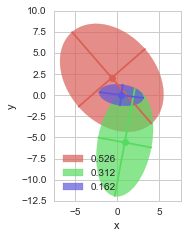

In [50]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm,ax=ax)

## 5.2 Goodness-of-fit statistics

In [51]:
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.013      0.025  1.694883e-08      0.011       0.144

In [52]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y')
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y')
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvWuQK2d5Lvq0unW/zH1mzX3NzLJ3jKkkNgaScEsMhOBD
QihyArlVkk04p/ZOICRUHczFMRVYARJiUhUn1MYJcMp2js3hFJs4UHtXQUhcIRWwY8w58QW81sya
Gc2MpJE0o7u61ZfzQ/N983Wru9UttWakcT9Vq9ZaUuvrVqv76ffyvO/LaZqmwYcPHz4uKALnfQA+
fPjwMUj4JOfDh48LDZ/kfPjwcaHhk5wPHz4uNHyS8+HDx4WGT3I+fPi40PBJzocPHxcaPsn58OHj
QsMnOR8+fFxo+CTnw4ePCw2f5Hz48HGh4ZOcDx8+LjR8kvPhw8eFhk9yPnz4uNDwSc6HDx8XGj7J
+fDh40LDJzkfPnxcaPgk58OHjwsNn+R8+PBxoeGTnA8fPi40fJLz4cPHhYZPcj58+LjQ8EnOhw8f
Fxo+yfnw4eNCwyc5Hz58XGgI530APs4fmqZBkiTIsgye5xEMBhEIBMBx3Hkfmg8ffYPTNE0774Pw
cX4QRRGlUgnJZBKtVgsAsL+/j4mJCSSTSQQCAZ/0fIw0fEvuRQxFUdBoNHB4eIh4PA5ZlhEMBqFp
GjRNg6IokGUZkiSB4zjwPO+Tno+Rg09yL0JomgZZlqEoCjiOg6IouH79OhRFgSAIUFUV9Xod4XAY
gnB6iRDSE0URgUAAPM+D53kIguCTno+hhe+uvsigqiparRbIz35wcIBisYiVlRWEQiFIkoRMJgOO
49BqtSAIAmKxGKLRKGKxGHie161H1uE4jpKdIAgd2/nwcV7wLbkXCYj7qSgKAECWZaTTaaiqimAw
iGQyCUmSEIlEEAwGMTY2hng8DlEUUa/XUSqVkM1mKekR4mPJTJZlaJoGURSRy+UwNzeHUCjkk56P
c4VPci8CqKoKWZahqio4jkOlUsHe3h4mJyeRSqWws7Oj257jOGiaBo7jEIlEEIlEMDk5CU3T0Gw2
0Wg0cHx8jEwmg2AwSAmPJb1arQZJkijpEffWt/R8nDV8krvgIHE0kkzIZDIol8tYXl6mlprTiAXH
cZTMWNKr1+s4Pj7GwcEBQqEQYrEYNE2jpAqcxgF90vNx1vBJ7oJCVVUoigJVVQEAkiRhd3cXoVAI
GxsbNKHQT7KAJT2yT2LpqaqK3d1dhMNhGs+LRqMIBNr6c5/0fJwVfJK7gFBVFfl8HqVSCSsrKzg6
OkImk8Hs7CwmJyc7iM1oyRF31S0CgQCN15XLZczPz9NMbbFYRLPZRDgc1rm3dqRXrVaRSqUQDod9
0vPRM3ySu2Ag7inQJo50Oo1Go4G1tTVEIpGO7Qcp+wgEAohEIojFYgDa5NtoNNBoNFAoFCCKIiKR
CLX0IpGIjvRyuRwEQYAsy76l56Nn+CR3QWDUvrVaLVSrVYyPj2NjY4OSh9VngcESHtAmvXg8jng8
DuCU9Or1OvL5PCU9YumR5AexLK3c21Ao5Gv0fFjCJ7kLAKP2LZ/PI5fLIRQKYXFx0fazZuTQq7vq
FkbSIxUYpApDlmVkMhnE43Fq6XVLZJDaW5/0fBD4JDfiINYb0CaJvb09yLKMS5cuoVwuO1pjWPTg
PM8jkUggkUgAADY3N5FKpSBJEnK5HFqtls7SMyO9VquFZrNJSY/jOASDQd+9fRHDJ7kRhdE9rVar
SKfTGB8fx8rKCmq1miPysrJ4vCC+ftfgOA6xWAzj4+MATi29er2ObDYLWZYp6cViMYTD4Q7SOzg4
oGv4lt6LEz7JjSBY7RsAZLNZHB0dYXFxEclkkm7XK8l4QQCDIBGjpSfLMiW9TCYDWZZ1cpVwOEyP
xcrS80nv4sMnuRGCpmkoFAoIBoOIRCJotVpIp9PgOA4bGxsIBoN0W6c37VnF3wYBQRCQTCYpsbOk
d3x8DEVRaMIlHA7rEhQs6ZGYHiE+n/QuFnySGxGQ0qyjoyMap9rb28P09DSmp6c7bsp+yWsUic+M
9Pb39+nfiqLomg2wpKeqKk3gsKQnCAIEQfBJb4Thk9wIQFEU2tASAI6OjiBJElZXV6kGrVewdars
axcBhKAI8bVaLZ2lp6oqJbxYLKaz4FjSa7VaqFQqmJub80lvBOGT3BDDmFxoNpuoVqsIh8O4cuWK
bcZwlN3QQSEYDCIYDCKVSgEAWq0W6vU6Go0GisUiNE3TWXqE9GRZRr1ep+4tx3G+pTdC8EluSMF2
DgGAYrGIbDaLSCSCsbGxrpIIpyTHxqjcfnbUQVpKjY2NQdM0naVXLBYBANFolDYSZS1e1tLzSW+4
4ZPcEILVvqmqiv39fTSbTaytrdGb78UAr2QsTgiH4ziEQiGEQiEd6dXrdVQqFYiiiK2tLVNLD/BJ
b5jhk9wQweie1ut17O7uIplM0tIsNxaamxZKg7DcvFjzvMiBJb1gMIhisYi5uTnU63XUajXk83kE
AgGdZMWK9IC2/IWImVk9n4/Bwye5IYFR+3Z4eIh8Po+FhQWMjY31tGY/OjkvhLwXBZqm0RrZUCiE
8fFxOsaxXq+jWq0il8uB53ldIoO14FRVRS6XQzweRzKZ1A0FIpUZPgYDn+TOGZqmoVar4eDgACsr
K1AUhbYl39jYQCgU0m3vNtbmBBc5BufUXXULjuMQDocRDocxMTGhI71KpUJJj20VzzYcMLP0yFAg
n/S8hU9y5wiSXCATsEhb8omJCczOzvZVPH+Rieus4YQozUhPFEU0Gg2Uy2Vks1naLRk4TWgY3VtJ
kgCgYyiQT3q9wye5cwLrnpLWSHt7e1haWqJlS2ZwQ15uSC6fz6NcLiMSidDRhD7a6OVhwc7HIKS3
s7MDQRA6hgKxk9AImZGhQ8aZtz7puYd/JZ8xzPq+pdNpaJqGK1euOCIXL91VIlOpVCqYnZ2lEopq
tYpGo6Fzt+x60g0rvHJX+12DZFxTqRSdgUFaxZdKJWQyGYRCIV0iw4r0Dg4OMD8/r5uE5pOeNXyS
O0MYp2aVSiXs7+9jcnKSzjjtBi9rUkn2luM4rKys0JkNxK1KJBKmrcuNXXwvOgYR13MzFIidhMZx
HBqNBq2C8S297vBJ7ozAat80TcP+/j5qtRouX75MJQpO4EWsjRT6Hx4eYnFxEfv7+6ZlXeTmmpqa
0nXxPTw8hCRJukyimSzCjwnqYUeWdkOBjo6OcHBwQIcCEWEy+Rzgu7d28EluwDArzdrd3UU0GsXG
xgZ4noeiKJ5r2qy2k2WZNtYk2dv9/f2u1opVF1+zNkfEHRsGnKWg2Mt12KFA5CFDLD1N03Djxg3T
oUAs6cmy7JMefJIbKIyF9YVCAblcDpcuXcLExAR9fRDCXbPtiHuaSqWwvLxM3c1eLniz3m71eh31
eh1HR0eQZRmFQgHJZJJWB7iFV0Q5LDd0P2TJkl6xWMT6+jpEUUS9Xu86FAgwJz1RFJFIJC58RYZP
cgOApmlQFAXPPPMMrly5AgDY39+HJElYX1+nzRwJ3Lqgbm9+o3tKCtSN25ALvReXWBAEpFIppFIp
aJqG7e1thMNhOqSG3KTkJhyl7O2gtHa9gPwuLOkB1kOB7Ejvxo0bWF1dpYJkIk5mLcKLgNG50kYE
xsL6Wq2GTCaDVCqFpaWlrlOznOixnIBsZ+ae9rqmU5BMYiKRoIkMo1CWyCfYTKLd9+gVw+I2A96Q
JSsoZmE3CY3EUNlW8ZFIBJqm0fNuZukRcfKok55Pch7CWJpFiuutrCcCctE6JTk3N+7169eRTCZ1
7qkZjGt6SQ5mQlljJnGQmVuviKVfeEly3WA3CS2Xy0GSJGiahqOjo45JaGR7WZY7WsWPIun5JOcB
iHsqyzLtP0a

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADSCAYAAABdE+UBAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAG91JREFUeJzt3XtQVOfdB/DvsssakYtDvYSoGNGEF0m8oImTKdoZoqXx
NU1TBvG2mSZMMp1pTdOqpRgREkFtU513Rq0dncm04j3mD5upU8dKGuqliWjBARS1GBSNaLzERSkL
u+f9g5zD7rq75+xyds85u9/PTGaEc3s2cL48zznPOT+TIAgCiIhkxGndACIyBoYFESnCsCAiRRgW
RKQIw4KIFGFYEJEiDAsig3C5XFi9ejWKiopgs9nQ1tbmsbympgYFBQUoKirC/v37PZY1NDTAZrNJ
X587dw6LFi2CzWZDcXExvv76a/kGCERkCIcPHxZKSkoEQRCEf//738JPf/pTaZnD4RBmz54t3Lt3
T+ju7hZ+/OMfC7du3RIEQRC2bdsmzJs3TygsLJTWX7x4sdDc3CwIgiDs2bNHWLt2rezx2bMgMojT
p09j5syZAIApU6agsbFRWvaf//wH6enpSElJgdVqxbRp03Dq1CkAQHp6OjZt2uSxr40bNyIrKwsA
4HQ6MWjQINnjW9T6IJF0+vRprZtAJJk2bZridf9dfxQu51C/y61WK5599lmfyzo7O5GYmCh9bTab
0dvbC4vFgs7OTiQlJUnLhgwZgs7OTgBAfn4+2tvbPfY1YsQIAMCZM2ewc+dO7Nq1S7bthgwLANi/
9p+aHNdut3v8UIyMn2Xg5q+cGdT6LudQDB+zzu/yW1dL/S5LTEzEgwcP+vflcsFisfhc9uDBA9n/
H4cOHcLWrVuxbds2pKamyrZdk2GI+8WW5uZmzJw5EzabDTabDYcOHdKiSUS6l5OTg9raWgBAfX09
nn76aWnZ+PHj0dbWhnv37sHhcKCurg5Tp071u6+DBw9i586dqK6uxpgxYxQdP+I9i+3bt+Mvf/kL
Bg8eDABoamrC66+/jjfeeCPSTSEylDlz5uD48eNYsGABBEHA2rVr8cknn+Dhw4coKirCb37zGxQX
F0MQBBQUFGDkyJE+9+N0OlFVVYW0tDQsXboUAPDcc8/h7bffDnj8iIeFeLHl17/+NQCgsbERly9f
xtGjRzF27FisXLnSY1xGRH3i4uLw/vvve3xv/Pjx0r/z8vKQl5fnc9vRo0dLt1PNZjO++OKLoI8f
8bDwvtgyadIkFBYW4plnnsHWrVuxZcsWlJSUyO7HbreHs5m6Pbba+FlIKc0vcM6ZMwfJycnSv9es
WaNoO60uzPGioD5F02fRK83nWRQXF+Ps2bMAgJMnTyI7O1vjFhGRL5r3LCoqKrBmzRrEx8dj2LBh
insWRBRZmoSF+8WW7Oxs7N27V4tmEFEQNB+GEJExMCyISBGGBREpwrAgIkUYFkSkCMOCiBRhWBCR
IgwLIlKEYUFEijAsiEgRzZ8NIYo1HV2tfpfp+a83w4Iowlpc+X6XZUWwHcHSc5ARkY4wLIhIEYYF
kUGoWb6wra0NCxcuxKJFi1BeXg6XyyV7fIYFkUH8/e9/h8PhwL59+7Bs2TKsX79eWtbT04N169bh
ww8/RHV1Nfbt2yfVL92+fTtWrVqF7u5uaf1169bhnXfewe7duyEIAo4ePSp7fIYFkUGoWb6wqakJ
zz//PABg1qxZOHHihOzxGRZEBuGvfKG4LFD5QrFymUgQBJhMJmldJW9G17wiWShjJ6JYpGb5wri4
OI91xTfsBxLxsPAeP4UydiKKRWqWL5w4cSI+//xzAEBtbS2mT58ue3zNK5J5j52OHz+OOXPmyO6H
RYbUwc9iHGqVLwSAkpISlJWVYePGjcjIyEB+vv+JYiLNK5KFMnYCWGRIDfwsxqJW+UIAGDduHHbu
3Bnc8YNaOwxCGTsRUeRpHhahjJ2IKPI0D4uSkhJs2rQJRUVF6OnpUTR2IqLI07wiWShjJyKKPM17
FkRkDAwLIlKEL7+JUi33u2XX6XXGwfLtepnJg8LdJDI4hkWUcQ+JjGdGB1xXnJvQ2tjusR2Dg3xh
WEQR8YSXCwlv7uu7BwdDIzwu2q/5Xabn1+oxLKJEqEHhTdyeoRE+3/S8oHUTQsILnFFkoEHhvS9x
f0quf1D0Y88iCrTc71Y1KNxJgdHY9zwPexmxiz0Lg4vUX332MohhYWBqXadQioER2xgWBhXpoBAx
MGIXw8KAtAoKEQMjNjEsDEbroBAxMGIPw8JA9BIUIgZGbGFYGITegkLEwIgdDAsD0GtQiBgYsYFh
oXN6DwoRAyP8Qql16m+bc+fOYf78+Vi4cCFKS0uNVev01Vdfhc1mg81mQ2lpqdbN0VzL/W5pZqbe
g0LEwAivUGqd+ttm8+bN+NnPfoY9e/bA4XDgH//4h+zxdTHdu7u7G4IgoLq6Wuum6IJRehO+ZDwz
WnoIjVPD1aW01ikAqdZpfX29z22ysrJw7949CIKABw8ePFLe0Bdd9CzOnz+Prq4uvPHGG3jttddQ
X1+vdZM0IfYmAGMGhYg9jPAIpdapv22efPJJVFVV4aWXXsLt27cxY8YM2ePromfx2GOPobi4GIWF
hfjyyy/x5ptv4m9/+1vAtIumimRXevszOy3jO2E5hj/hOs7wsSn4qvU2mu72It0Smfq10V6RLJRa
p/62qaqqwq5du/DUU09h165dWL9+PcrLywMeXxdhMW7cOIwdOxYmkwnjxo3D0KFDcevWLaSlpfnd
JloqkrXc74bFrE1PItxVvJIm972FKykp/MORWKhIlpOTg08//RRz584NWOs0ISEBdXV1KC4uhslk
8rlNSkqK1OMYMWIEzpw5I3t8XYTFgQMHcOHCBVRUVKCjowOdnZ0YPny41s0Ku3A+Wq4nvH6hjlBq
nfraBgAqKyvxy1/+EhaLBfHx8VizZo3s8U2CIAjh/pByHA4HSktLcf36dZhMJixfvhw5OTl+1z99
+jT2r/1nBFvYT62/YHoIikj9NW6NwLswtOpZzF85E9OmTVO8/unTp1GNL/wut+H5oPYXSbroWVit
VmzYsEHrZkSMHoIiksQ7JNSn+U6H/4WpkWtHsHQRFqS9hod3pH9PTgjPbyyHI31SXZlaNyEkDIsY
4h4IAOCEE+aHPQCACRNG9q936dG/fAMNEM6/MD6GRYRFcgjiHQ6AZyj4G+e7rwMAly51oOHhHQZG
jGNYRBnvgPA+8UMxYcJI1QODjIdhESXcQ0KNgPAm7lMcogwkNDKeGY2Wxnb2LgyGYWFg4ehFyHHv
ZQADCw0OR4yFYWFA4e5FyBGPOZDQ4PUL42FYRNBAH6wKNSTqHbd8fr/X7ITF8V/p6ynW4GbN+rqD
EkxoMDCMhWERYaHcCQklJLwD4ukxIx5Zp9NuR+K3d0MuXL3pM1SUBkiowxMGhnEwLHROPPmUhISS
gPDH17reASIXHN7DEwZGdGFYREgoQ5BQgiKYgJDjvq9ggiOUXgYDQ/8YFhEUzBBEaVAEComzwvWA
2zofc8IsBH4HxCTTEz73X3/1pvRvX8ERSi+DczD0jWGhQwMNCveQyHrcf09D7knNczdueuxLDA73
Y7r3OPyFxiUf08f94RwM/WJYREAwU7yVBIVcSLgHxJ24Fr/76U10oifO7HNZqivTYz/+gkNJaEyY
MBINlzqCulPC4Yj+MCx0RM2gcA+Jiam+92fvtCMp8dGeRfOdjkdCJuvx/icl3YPDX2gMJDA4HNEn
hoXOKLmY6e8ipveQwzskUuJPenydmOyE2fxoz2Ji6gseX4vhIT5aLR5HDA3v4ckFt+sZFD0YFlHg
rHA94NDDPSSeShol/dvXNYuL9mse63/T84IUOs13+vbrHhq+AgPAgHsXpD+6KAVAfSYnpAZ1MTAQ
8QQXT/ynkkZ

In [53]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log


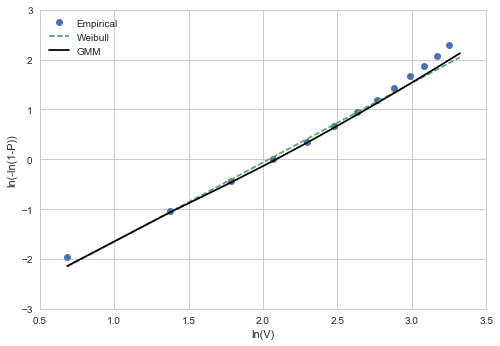

In [54]:
x = linspace(0, max_speed, 15)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label = 'Empirical')

# 2. Weibull distribution
weibull_params = sp.stats.weibull_min.fit(df.speed, loc=0)
y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y = array(list(zip(*y_))[0])
plot(log(x), log(-log(1-y)),'-', color='black', label = 'GMM')

plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

Direction Distribution Comparison


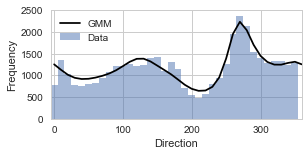

In [55]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction',ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print(title)

Speed Distribution Comparison


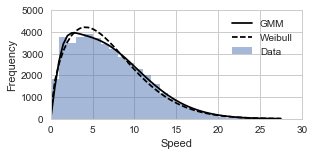

In [56]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df.speed)/0.02
plot(x, y,'-', color='black', label='GMM')

# 2. Observation
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')

# 3. Weibull
y_weibul = sp.stats.weibull_min.pdf(x, *weibull_params)* len(df.speed)
plot(x, y_weibul, '--', color='black', label='Weibull')   

title='Speed Distribution Comparison'
plt_configure(xlabel='Speed',ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)
print(title)

In [57]:
# %%time
incre = max(SECTOR_LENGTH, 10)
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(gmm, df, angle, incre) 
                                        for angle in arange(0, 360, incre))  
# This R square is computed as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
print(true_R_square(density_collection))

0.90145923771


## 5.3 Sectoral Comaprison

In [58]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        direction_prob = integrate.nquad(f, [[0, inf],
                                             [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)
        
        fig = plt.figure(figsize=(13,1.3))
        x = linspace(0, sub_max_speed, 20)
        # 1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        # 1.1. Data Histogram
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')             
        # 1.2. Model Distribution
        y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], 
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                                 for x_ in x]
        y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        # 1.3 Weibull Distribution
        y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        # 2.1. Empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_ecdf = ecdf(x)
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_cdf_gmm = array(list(zip(*y_))[0])/direction_prob[0]
        # 2.3 Weibull
        y_cdf_weibull = sp.stats.weibull_min.cdf(x, *weibull_params)      
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        plt.gca().set_xlim(right = log(max_speed+1))
        
        print('%s (%s - %s) degree' % (angle, start_angle, end_angle)     )

        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'],bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                    for x_ in bins[:-1]]
        density_expected_gmm = array(list(zip(*density_expected_ ))[0])/direction_prob[0]
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.weibull_min.cdf(bins[1:], *weibull_params) - sp.stats.weibull_min.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob[0], 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print('data size:', len(sub_df), 'weight', len(sub_df)/len(df))
        print('GMM', 'Weibull')
        print('R square', R_square_gmm,  R_square_weibull)
        print('max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()])
        print(' ')
    return max_diff_array, curve_collection

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:60: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: divide by zero encountered in log


5.0 (-5.0 - 15.0) degree


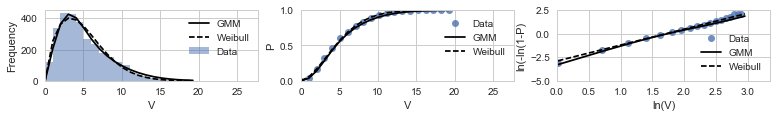

data size: 2865 weight 0.06704106704106703
GMM Weibull
R square 0.985353680773 0.976488727668
max diff: 0.0370615770215 0.0251371591433 speed value: 5.06140350877 y gmm 0.563287463118
 
25.0 (15.0 - 35.0) degree


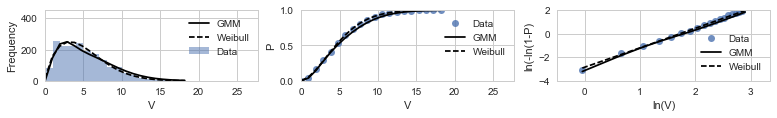

data size: 1811 weight 0.04237744237744238
GMM Weibull
R square 0.958471218361 0.966459005373
max diff: 0.0449587900002 0.0154824803978 speed value: 7.65614035088 y gmm 0.763434362954
 
45.0 (35.0 - 55.0) degree


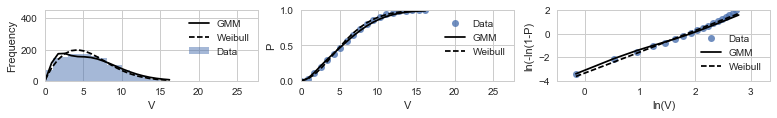

data size: 1555 weight 0.03638703638703639
GMM Weibull
R square 0.963965220159 0.95516320782
max diff: 0.034207917926 0.0256750005219 speed value: 11.0728070175 y gmm 0.908557355386
 
65.0 (55.0 - 75.0) degree


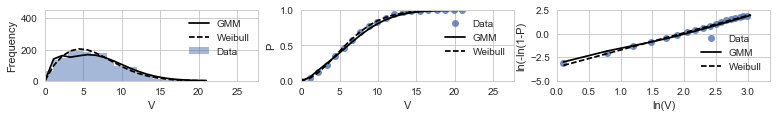

data size: 1766 weight 0.041324441324441324
GMM Weibull
R square 0.952421443909 0.972469598058
max diff: 0.0419682102582 0.0179058534251 speed value: 8.8350877193 y gmm 0.734362480569
 
85.0 (75.0 - 95.0) degree


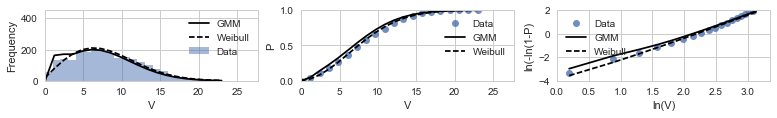

data size: 2291 weight 0.05360945360945361
GMM Weibull
R square 0.921428005948 0.947551133348
max diff: 0.062478599105 0.026908730315 speed value: 9.6701754386 y gmm 0.721579428437
 
105.0 (95.0 - 115.0) degree


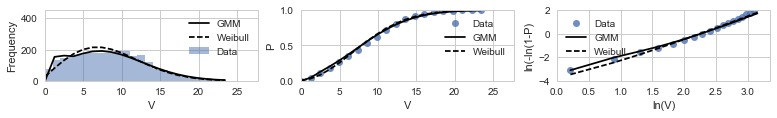

data size: 2494 weight 0.05835965835965836
GMM Weibull
R square 0.950696927058 0.913534271724
max diff: 0.0339241853108 0.0371941454414 speed value: 7.39473684211 y gmm 0.468567328855
 
125.0 (115.0 - 135.0) degree


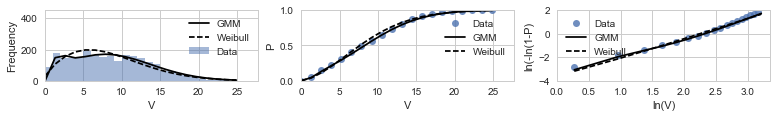

data size: 2445 weight 0.057213057213057215
GMM Weibull
R square 0.938941050471 0.830426522347
max diff: 0.0233995159179 0.0515880535199 speed value: 15.7157894737 y gmm 0.892755903305
 
145.0 (135.0 - 155.0) degree


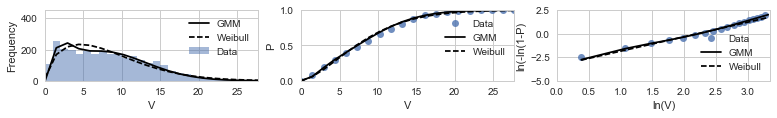

data size: 2833 weight 0.0662922662922663
GMM Weibull
R square 0.941356449871 0.865782390754
max diff: 0.0338245691826 0.0420080243809 speed value: 11.6912280702 y gmm 0.767675610482
 
165.0 (155.0 - 175.0) degree


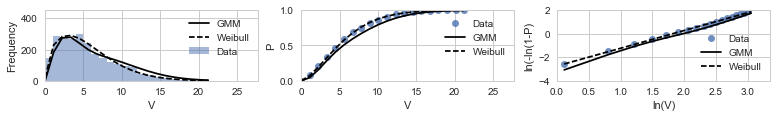

data size: 2417 weight 0.056557856557856556
GMM Weibull
R square 0.927604598725 0.97534919852
max diff: 0.0903739885994 0.0171521418924 speed value: 6.70526315789 y gmm 0.593945415621
 
185.0 (175.0 - 195.0) degree


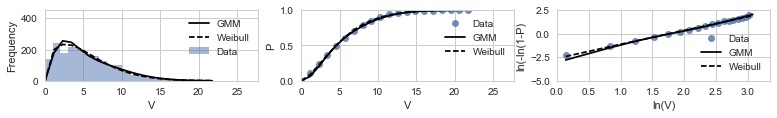

data size: 1833 weight 0.042892242892242895
GMM Weibull
R square 0.919569410756 0.967592958321
max diff: 0.0439838737208 0.0195272299909 speed value: 1.14473684211 y gmm 0.0596713363174
 
205.0 (195.0 - 215.0) degree


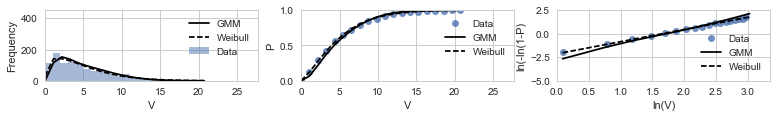

data size: 1025 weight 0.023985023985023984
GMM Weibull
R square 0.864408267184 0.955565902582
max diff: 0.0781404045967 0.0199180167402 speed value: 2.18070175439 y gmm 0.217469351501
 
225.0 (215.0 - 235.0) degree


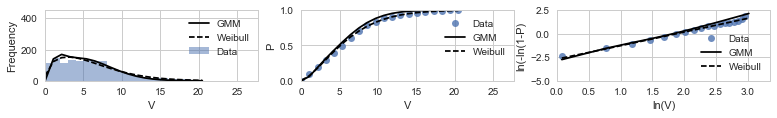

data size: 1363 weight 0.03189423189423189
GMM Weibull
R square 0.893910767726 0.928115728643
max diff: 0.0566749615619 0.0346630238588 speed value: 5.38596491228 y gmm 0.549705042266
 
245.0 (235.0 - 255.0) degree


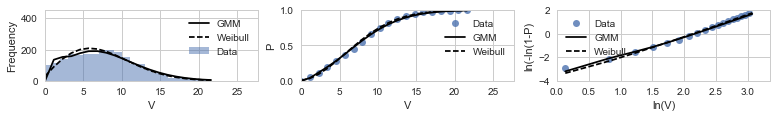

data size: 2213 weight 0.051784251784251785
GMM Weibull
R square 0.947911166752 0.929508479081
max diff: 0.0261013330754 0.0322118433542 speed value: 12.5052631579 y gmm 0.853247966518
 
265.0 (255.0 - 275.0) degree


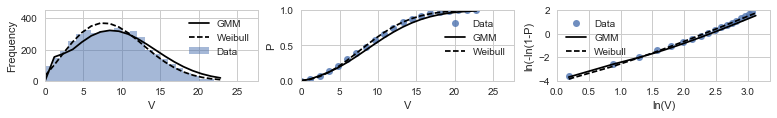

data size: 4309 weight 0.10083070083070084
GMM Weibull
R square 0.941075680714 0.959300094337
max diff: 0.0658488806369 0.0234711353751 speed value: 13.2096491228 y gmm 0.759632669607
 
285.0 (275.0 - 295.0) degree


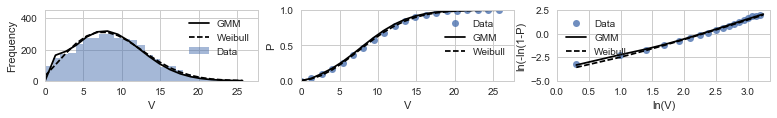

data size: 3672 weight 0.08592488592488592
GMM Weibull
R square 0.974408680813 0.972223827624
max diff: 0.0424390204248 0.0220437653595 speed value: 10.8210526316 y gmm 0.715913965959
 
305.0 (295.0 - 315.0) degree


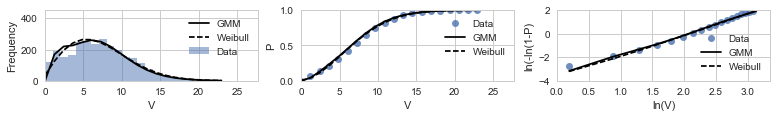

data size: 2682 weight 0.06275886275886276
GMM Weibull
R square 0.935783044263 0.925479874617
max diff: 0.0385486393873 0.0299904808781 speed value: 7.24736842105 y gmm 0.570241405979
 
325.0 (315.0 - 335.0) degree


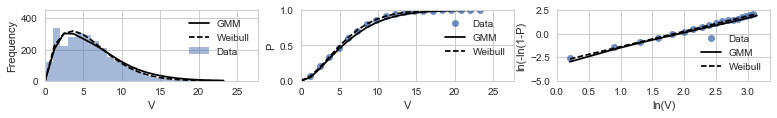

data size: 2638 weight 0.06172926172926173
GMM Weibull
R square 0.928057598108 0.946551145831
max diff: 0.0443233961496 0.0215739197092 speed value: 8.55964912281 y gmm 0.755145898771
 
345.0 (335.0 - 355.0) degree


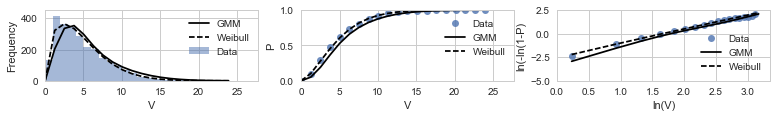

data size: 2523 weight 0.05903825903825904
GMM Weibull
R square 0.89026222088 0.973843558508
max diff: 0.106241518698 0.0178030889516 speed value: 3.77105263158 y gmm 0.367004616855
 
Wall time: 1min 4s


In [59]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

0.9395426229327739 0.9419721129319132


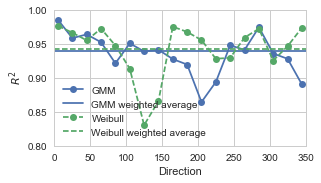

In [60]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$")
plt.gca().set_ylim(top=1)
print(gmm_mean, weibull_mean)

0.05002439470660881 0.026949732756024695


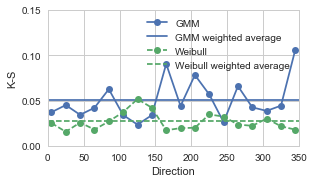

In [61]:
gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S")
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim, bottom=0)
print(gmm_mean, weibull_mean)

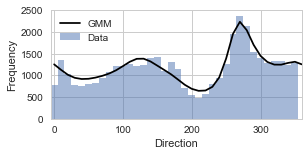

In [62]:
# Compare direction weight with previous figure
display(dir_fig)

### 5.3.1 Data Variability, by Bootstrap (Resampling)

In [63]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [64]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: divide by zero encountered in log


345.0 (335.0 - 355.0) Degree Speed Distribution
0.105208058181 3.0 0.257851791205


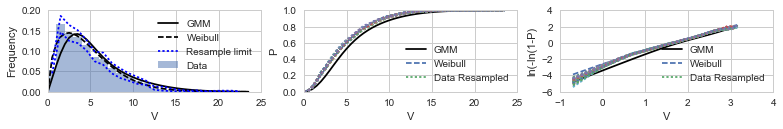

In [65]:
fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

x = arange(0, sub_max_speed, 0.5)

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02  
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_gmm_cdf,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color = 'black',label='GMM')

# 3. Weilbull 
y_weibull = sp.stats.weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = sp.stats.weibull_min.cdf(x, *weibull_params)
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_weibull_cdf,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in range(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
        plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel='V',ylabel='ln(-ln(1-P)',legend={'loc':'best'})

print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
plt_configure(ax=ax1, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_gmm_cdf)
print(diff.max(), x[diff.argmax()], y_gmm_cdf[diff.argmax()])

### 5.3.2 Time Variability

In [66]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))
 
x = arange(0, sub_max_speed, 0.5)

# 1. GMM
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
y_gmm = array(list(zip(*y_gmm_))[0])/direction_prob[0]/0.02
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],
                         [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(list(zip(*y_gmm_cdf_))[0])/direction_prob[0]

ax2.plot(x, y_gmm_cdf,'-', color='black', label = 'GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color='black',label='GMM')

# 2. Weibull
y_weibull = weibull_min.pdf(x, *weibull_params)
y_weibull_cdf = weibull_min.cdf(x, *weibull_params)
ax2.plot(x, y_weibull_cdf,'--', label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
ax1.set_zlim(bottom = 0)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: divide by zero encountered in log


345.0 (335.0 - 355.0) Degree Speed Distribution


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXl4G+W5/n9rJGuxbMu7HW9JnIWQQlgChwZoytYFKL/S
llBIyQHK0nKAlqWlkEM3oECTcgqlZWkhpXB6AoXSA/lC6LkCSaCUtkDZS4jJ4sSJbUnWYq2z//5w
3smr8Yw0kka2ZM3nuriIZVszGkvvPc/zPs/92GRZlmFhYWFhYWGRFWa6T8DCwsLCwqISsATTwsLC
wsLCAJZgWlhYWFhYGMASTAsLCwsLCwNYgmlhYWFhYWEASzAtLCwsLCwMYAmmhYWFhYWFASzBtLCw
sLCwMIAlmBYWFhYWFgawBNPCwsLCwsIAlmBaWFhYWFgYwBJMCwsLCwsLA1iCaWFhYWFhYQBLMC0s
LCwsLAxgCaaFhYWFhYUBLMG0sLCwsJgy9u7di29961s499xz8e///u+4/PLLMTAwgHvvvReHHnoo
RkdHlZ8dGxvDJz7xCTz99NMYGhrCIYccgl//+tcZz/fNb34Tq1atmpJztwTTwsLCwmJKSKVSuOKK
K3DxxRfjD3/4Ax599FFcddVVuOWWWwAAc+bMwcaNG5Wff/755zFr1izl676+Pvz5z39Wvg6Hwxgc
HJyy83dM2ZEsLCwsLMqG7373u3jyySdNfc4VK1Zg7dq1ut/fvHkzPvnJT+Koo45SHluyZAkeffRR
/PKXv8QZZ5yBF154ARdddJHy8yeffLLys01NTWhsbMSOHTswb948bNy4EZ///OfxxhtvmPo69LAi
TAsLCwuLKWFoaAh9fX3K11dccQVWrVqFz3/+8xgZGUFrays8Hg/27t2LwcFBdHZ2wuVyZTzHmWee
ieeeew4A8OKLL+K0006bsvO3IkwLCwuLKmTt2rVZo8FS0NnZiffff1/5+v777wcAnHvuuRBFEcBB
QRQEAWeddRZeffXVjOc47bTT8LWvfQ1f/vKX0dbWBrfbPWXnb0WYFhYWFhZTwqmnnorXXnsNb7/9
tvLY4OAgRkZGYLPZAACf+9zn8OKLL+KNN97AcccdN+k5vF4v5s6di7Vr1+ILX/jClJ07YAmmhYWF
hcUU4fV6cf/99+N3v/sdLrjgApx33nlYvXo1brrpJnR1dQEA6uvr0dnZicWLF4NhtCXqrLPOwptv
volly5ZN5enDJsuyPKVHtLCwsLCwqECsCNPCwsLCwsIAlmBaWFhYWFgYwKqStahKJEmCIAjgOA52
ux0Mw8But8NutyvFBxYWFhY0lmBaVBWSJGF0dBRNTU3K17IsQ5ZlJBIJxGIxdHV1gWEY2Gw2S0gt
LCwULMG0qAokSYIoipAkCcPDw2hsbIQkSeB5HjU1NYoYEgElPWGkJs5msykCagmphUV1YgmmxYyG
pF7pYnBZlhEIBBAKhWCz2SCKIpxOJxiGgSAISCQScDqdcDgcGWJoVEgdDofytYWFxczBKvqxmJGI
ogiO48BxnCJugiAokxA4jsPcuXMxd+5c9Pf3o729HS6XC7IsIxwOY8+ePdixYwf27NmDkZERhMNh
JBIJRXyJUAIHhVQQBLAsq6R24/E4kskkUqkUWJaFKIqwurgsqpkLL7wQ7777LoCJz+DSpUvx0EMP
Kd9ftWoVPvzww0m/9/LLL+OJJ57A0NAQzj33XMPHO+GEE5Tn3bFjR5Fnb0WYFjMMURSV1CsRNUEQ
EAwGEQ6H0dDQAIZhMGvWLNjtdqXox+PxQJZlsCyLnp4e5blYlgXHcWBZFvF4XBFgl8sFp9MJp9Op
/DtXRMqyLACAYRglAiVpXSsitagGTjjhBLzxxhtYsmQJ3nzzTZx44onYunUrLr30UrAsi3379mHR
okWTfm/58uUAJrxopxNLMC1mBFpCyfM8gsEgIpEIfD4f5s2bB6fTiVgslpFS1cNut6O2tha1tbUZ
j5PqWiKm8XgcLMvCZrNlCCj5t3qfkxZSnueViJXsi9L/toTUopTMmTP5sfPPB+64o7Dv796d/XjH
H3887rvvPnz961/H1q1bsWLFCvzsZz9DLBbDBx98gH/7t3/D66+/jp///Oew2+3o7e3FLbfcgg0b
NmDnzp0477zzEAqF8M1vfhNjY2M46aSTcOWVV+LGG2/EGWecgeXLl+Pll1/G888/jzvvvDO/i2EA
SzAtKhotoeQ4DsFgENFoFI2NjZg/fz5qampyPpfNZjOUMnU4HHA4HBlCSkSQiGg6ncb4+Dg4joPN
ZlNElBZTIo50alcQBOXfREhp4RRFUVOELSwqgcWLF2Pnzp2QZRmvv/46rrvuOixbtgx//etf8dFH
H+HEE0/E97//ffzP//wPWlpacPfdd+NPf/oTHI6DUpVMJrF27VrU1tbia1/7Gk499dQpO39LMC0q
DlmWM6peaaEMBAIYHx9HU1MTFixYkPFBIxgVxnyw2WyKkHq93oxzJXubHMchlUohEokoqWBaRMn/
iTjSlbuSJAEAPv74Y8yZM0cpLFIXG9G/Z2GRi1wRYbHfV8MwDBYtWoSXX34ZbW1tcDqdWL58ObZs
2YJt27bha1/7Gr7//e/jmmuuAQCk02kcf/zxmD17tvIcixYtQn19PQDg8MMPx65duzKOUco6AUsw
LSoGPaFkWRaBQACxWAzNzc26QknQE8xSCWlNTc2kCFeWZfA8rxQmJZNJRUgdDsek/VEipOQ5gUwh
pVPMenukFhblwAknnIAHH3wQZ555JgBg6dKluO+++wBMDIju7OzEfffdh/r6erz44ouora3F8PCw
8vs7duxAIpGAy+XCu+++i69+9at47bXXEAgEAAD/+te/SnbulmBalD1EKNUVqizLwu/3Ix6PGxJK
NdMZiZH9TqfTmfE4EVJ6f5TjOPA8D4fDAUmSEAqF4Ha7ld9XR5W0kHIcpxxPLaTqIiULi6ng+OOP
x80334w1a9YAAJxOJ+rr63HooYeCYRj853/+Jy6//HLIsgyv14s1a9ZkCKbP58O1116LUCiEM844
A/Pnz8eKFSuwevVqbNiwAXO0Nl5NwppWYlG2kH1B0o5BFvd0Oo1AIIB4PI6Wlha0tLTAbrcbft6B
gQH09vbC7XYrggIALMtieHi4pB+4QpFlGRzHYc+ePWhsbFREVRAE1NTUTErt0mYMes8HTBZSh8Nh
7Y9aWOhgRZgWZYeWUNpsNqRSKQQCASSTSbS0tKCrqysvoSSUIvVaakjhkM1mQ3Nzs/K6iVsRiUhJ
oRERUvX+KBHSfCJSy9XIwmICSzAtygZZlpVmf5/PpyzsyWQSgUAAqVQKra2t6OnpKXpPbqr2MEsN
wzBwuVxwuVwZj0uSlNH6QvZHiauRuvVFq2CICCl9TUg617IHtKhGLMG0mHboiDKZTGJ8fByNjY1I
JpPw+/1Ip9Noa2tDb2+vKcUr1bC4MwwDt9sNt9ud8TjtgMSyLJLJJFiWhSRJmq0vWvucantAcjyS
1uV5Hm63O2da2MKi0rAE02La0Eq9MgwDnuexa9cucByHtrY29PX1mVrlOZVVsuUGcTXyeDwZjxMh
VRcbybKs2fqSzYxh9+7d6OrqUlLIlmG9xUzBEkyLKUevmCcej2N0dBQcx6GrqwuNjY0lWVhpYawG
kTSCnpDmcjVSi6ndbs/4m1qTXyxmEpZgWkwZtEk5cDA1GovF4Pf7IYoiGhoakEwmlXmVU4klnpMp
xNWIbn0xEpHqpXatyS8W5YYlmBYlh5gNkAWSCNP4+DgCgQAkSUJ7e7silslksqTnQxb1WCyGaDSq
VJMWUnFbjeRyNRocHITD4UA6nUY0GjXkakQ/h2VYb1GuWIJpUTJoVx6SppNlGdFoVHHlaGtrQ0ND
g7LwlTrKIwv

### 5.3.3 Adjacent Sector Variability

In [ ]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [ ]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

# 6. Result Variability & Cross-Validation

In [ ]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}

## 6.1 Variability of the Result

In [ ]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df, FIT_METHOD, NUMBER_OF_GAUSSIAN, config) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax)
    plt.show()
    
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print('')

## 6.2 Cross-validation, to select the number of Gaussian

In [ ]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print('Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold) 

for number_of_gaussian in gaussian_number_range:
    print( '  ')
    print('Number of gaussian', number_of_gaussian)
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index, FIT_METHOD, number_of_gaussian, config) for train_index, test_index in kf)                        

    CV_result_train, CV_result_test = list(zip(*CV_result))
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print('Train')
    pretty_pd_display(CV_result_train)
    print('Test')
    pretty_pd_display(CV_result_test)

In [ ]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print('Train gof mean, std')
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print('Test gof mean, std')
display(test_scores_mean)

In [ ]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '--', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print(column)
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Gaussian Distribution', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    if column == 'R_square':
        plt.gca().set_ylim(top=1)
    if column == 'K_S' or column == 'Chi_square':
        plt.gca().set_ylim(bottom=0)
    plt.margins(x=0, y=0)
    plt.show()

In [ ]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [ ]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(file_path)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)